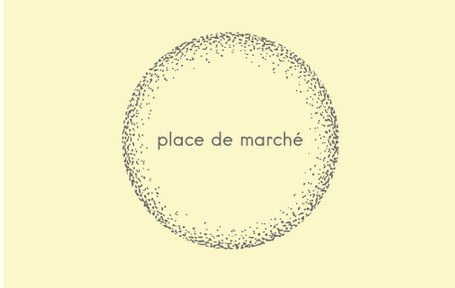

# <a name = "sommaire"> Sommaire 

- <a href ="#id_app"> Présentation du projet </a>
- <a href ="#import"> Importation des bibliothèques et des données </a>
- <a href ="#fonction"> Fonctions de visualisation et prétraitement </a>
- <a href ="#desc"> Description du jeu de données </a>
- <a href ="#nett"> Prétraitement:  </a>
    - <a href ="#nett_col"> Concaténation du nom du produit avec la description </a>
    - <a href ="#nett_col2"> Prétraitement de la description </a>
    - <a href ="#nett_col3"> Nombre de cluster </a>
- <a href ="#Extract"> Extraction des features de texte:
  - <a href ="#bow"> Bag of words
    - <a href ="#bow1"> CountVectorizer
    - <a href ="#bow1"> TF-IDF
  - <a href ="#WE"> Word embedding
    - <a href ="#WE1"> Word2Vec
  - <a href ="#SE"> Sentence embedding
    - <a href ="#SE1"> BERT
    - <a href ="#SE2"> USE
- <a href ="#Extract1"> Extraction de features d'image:
    - <a href ="#EXT1"> ORB
    - <a href ="#EXT2"> VGG16
- <a href ="#Extract3"> VGG16 + TF-IDF

# <a name = "id_app"> Présentation de la problématique</a> <a href ="#sommaire"> Retour au sommaire</a>

La problématique ici est de trouver une façon d'automatiser l'attribution de catégories aux articles sur une marketplace en ligne que l'entreprise souhaite lancé. Actuellement, cette tâche est effectuée manuellement par les vendeurs et, est peu fiable. Pour améliorer l'expérience utilisateur pour les vendeurs et acheteurs il est important ici  de trouver un moyen d'automatiser cette tâche de manière à ce qu'elle soit plus efficace et de fonctionner à grande échelle. L'objectif principal est d'étudier la faisabilité de créer un moteur de classification d'articles en différentes catégories, avec un niveau de précision suffisant. Comme l'objectif est d'étudier la faisabilité, tous les models seront exécutés avec les paramètres par défaut.

# <a name = "import"> Importation des bibliothèques et des données</a> <a href ="#sommaire"> Retour au sommaire</a>

In [1]:
!pip install word2number &> /dev/null 
!pip install unidecode &> /dev/null 
!pip install contractions &> /dev/null 
!pip install -q -U "tensorflow-text==2.8.*" &> /dev/null 
!pip install scikit-learn-intelex &> /dev/null
#!pip install umap-learn &> /dev/null

In [3]:
#from sklearnex import patch_sklearn
#import sklearnex
#patch_sklearn('KMeans')
#sklearnex.unpatch_sklearn()


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import unidecode
import contractions
from word2number import w2n

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#import umap

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model

import gensim
from gensim.models import Word2Vec

from skimage import color, exposure
from skimage.filters import gaussian
from skimage import img_as_ubyte
from skimage.transform import rescale
import cv2

import warnings
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/P6 classification/data/flipkart_com-ecommerce_sample_1050.csv')

# <a name = "fonctions"> Fonctions de visualisation et de prétraitement</a> <a href ="#sommaire"> Retour au sommaire</a>

In [4]:
def text_preprocessing(text: str, number = True, final_join = True) -> str:
  """Prétraitement d'un texte en supprimant les stop words, les ponctuations, les raccourcis d'un mot et traiter la base d'un mot avec la lemmatisation
  Args:
      text (str): Texte à nettoyer
      number (bool, optionnel): Permet de supprimer les nombres du texte. Initialiser par True par défaut
      final_join (bool, optionnel): Initialisé a False le prepocessing renvoie une liste de mot par phrase. Initialisé a True par défaut
  Returns:
      str:  Retourne le texte prétaité sous forme de chaine de caractère si final_join est True sinon une liste de mots"""
  
  words = pd.read_json('/content/drive/MyDrive/P6 classification/data/stop_words_english.json')
  wdr = list(words[0])

  stop_words_nltk = stopwords.words('english')

  stop_words_en = list(set(wdr+stop_words_nltk))
  wd = WordNetLemmatizer()
  # Text en minuscule
  sentence = text.lower()

  # Enleve tout accent
  text = unidecode.unidecode(sentence)

  # Redefinir les mots raccourcis exemple : we're -> we are
  text1 = contractions.fix(text)

  # Création des tokens
  text_token = word_tokenize(text1)

  # Enlever les ponctuations
  text_no_punct = [''.join(c for c in s if c not in string.punctuation) for s in text_token]

  # Suppression des stopwords
  text_no_stop_words = [i for i in text_no_punct if i not in stop_words_en]


  # Suppression des nombres
  if number:
    new_text =  [item for item in text_no_stop_words if not item.isdigit()]
  else: new_text = text_no_stop_words

  # Suppression des espaces en trop 
  new_text1 = [item for item in new_text if item != '']

  # Lemmatizer (base d'un mot)
  #final_text = [wd.lemmatize(i) if len(i) > 2 else i for i in new_text1] 
  final_text = [wd.lemmatize(i) for i in new_text1] 

  # Garder seulement les mots avec une longueur de 2
  #final = [word for word in final_text if len(word) > 2]

  # Text final retourner
  if final_join:
    return ' '.join(final_text)
  else: return final_text




def simple_bag_of_words(feature_extraction, dataframe: pd.DataFrame, column = 'description_new', features_names=False):
  """Crée une matrice de fréquence de mots à partir d'une colonne texte
     Args:
         feature_extraction: modèle de feature extraction type CountVectorizer ou Tf–idf
         dataframe (pd.Dataframe): Dataframe sur lequel effectuer le feature extraction
         column (str, optionnel): Nom de la colonne
         features_names (bool, optionnel): Renvoie le nom des features extraites
     Returns:
        list, np.array: Retourne le nom des features extraites en plus de la matrice de fréquence d'un mot
  """
  vectorizer = feature_extraction
  X = vectorizer.fit_transform(dataframe[column])
  if features_names:
    names = vectorizer.get_feature_names_out()
  else: names = []
  return X, names


def visualizer(df: pd.DataFrame, clf):
  """Permet de visualiser les différents clusters en 2 dimensions avec TSNE et visualiser la silhouette score
     Args:
        df (pd.DataFrame): Caractéristique d'entrée
        clf: Modèle de clustering qui dispose de n_clusters comme paramètre
  """
  fig, axs = plt.subplots(1, 2, figsize = (20, 12))
  visualizer = InterclusterDistance(clf, embedding = 'tsne', ax = axs[0])
  visualizer.fit(df)
  visualizer.finalize() 

  visualizer = SilhouetteVisualizer(clf, colors='yellowbrick', ax = axs[1])
  visualizer.fit(df)
  visualizer.finalize() 



def reduc_tsne(data: pd.DataFrame):
  """Permet de faire une réduction à 2 dimension avec TSNE
     Args:
         data (pd.DataFrame): Dataframe sur lequel faire la reduction de dimension
     Returns:
         np.array: Retourne les deux premières composantes de TSNE"""
  tsne = TSNE(n_components = 2, learning_rate='auto', init = 'random', perplexity = 30, random_state = 0)
  return tsne.fit_transform(data)

def categories(x:str)-> str:
  """Retourne la première chaine de caractères contenu dans x, en enlevant les crochets et le sépareteur ">>"
  Args:
    x (str): Chaine de caractère à traiter
  Returns:
    str: Retourne la première chaine de caractères contenu dans x, en enlevant les crochets et le sépareteur ">>" """

  line = x.replace('["', '').replace('"]', '')
  line_s = line.split('>>')
  line_strip = [i.strip() for i in line_s]
  return line_strip[0]




def sentence_2_vec(sentence:str, model):
  """Convertit une phrase en un vecteur en utilisant un modèle de représentation de mot
  Args:
    sentence (str): Texte à convertir en vecteur
    model: Modèle de représentation de mots
  Returns: 
    np.array: Vecteur de représentation de la phrase
  """
  # vecteur pour chaque token
  model_vectors = model.wv

  # dimension de représentation
  p = model.vector_size

  # init vecteur
  vec = np.zeros(p)

  # nb tokens trouvés 
  nb = 0

  # Traiter chaque token de chaque phrase
  for tk in sentence:

    # Traiter seulement les tokens reconnus
    try:
      val = model_vectors[tk]
      vec += val
      nb += 1
    except: 
      pass
  # moyenne des valeurs uniquement si on trouve des tokens reconnus
  if nb > 0:
    vec = vec / nb
  
  return vec


def int_labels(x, l):
  """Renvoie l'indice d'un élément dans une liste
  Args:
      x (str): Élément à rechercher dans la liste
      l (list): Liste dans laquelle rechercher l'élément
  Returns:
      int: Indice de l'élément dans la liste. -1 si l'élément n'est pas trouvé"""

  for key, lab in enumerate(l):
    if lab in x:
      return key
  return -1


def build_histogram(kmeans, des, image_num):
  """
   Construit un histogramme de visual words d'une image donnée en utilisant le modèle de kmeans
    
  Args:
      kmeans:  Modèle KMeans déjà entrainé
      des (np.array): Un tableau de descripteur à classer
      image_num (int): Numéro de l'image associée aux descripteurs
        
  Returns:
      np.array: Un vecteur de taille len(kmeans.cluster_centers_) avec une pondération
    """
  # prédiction de chaque descripteur
  res = kmeans.predict(des)

  # histogramme de taille k
  histo = np.zeros(len(kmeans.cluster_centers_))

  # nombre de descripteur
  nb_des = len(des)

  if nb_des == 0 : 
    print("problème histogramme image  : ", image_num)

  # création de l'histogramme avec une pondération
  for i in res:
    histo[i] += 1 / nb_des
  return histo


def kmeans_result(embedded, dataframe, name_col):
  """Entraine un KMeans et ajoute les labels dans un dataframe
  
  Args:
    embedded: Tableau numpy avec les données sur lesquelles appliquer le Kmeans
    dataframe: dataframe auquel ajouter les résultats
    name_col: nom de la colonne dans le dataframe où seront ajoutées les labels

  Returns: 
    pd.DataFrame: Retourne le dataframe avec une colonne supplémentaire contenant les différents labels"""
  model = KMeans(7, random_state=0).fit(embedded)
  kmeans_df = dataframe.copy()
  kmeans_df[name_col] = model.labels_
  return  kmeans_df
  
def transform_conf_mat(y_pred, list_corresp):
  df_labels = pd.Series(y_pred).to_frame('y_pred')

  return df_labels.y_pred.apply(lambda x: np.array(list_corresp[x]))



def vis_true_pred(embedded, dataframe, y_true, y_pred):
  """
  Affiche deux nuage de points à deux dimensions obtenues grâce à une réduction de dimension.
  Les couleurs des points sont basées sur la valeur de y_true pour le premier nuage de points et y_pred pour le second nuage de points
  Agrs:
    embedded: tableau de données de dimension (n, 2) contenant les projections des données
    dataframe: dataframe contenant les données y_true et y_pred
    y_true: nom de la colonne du DataFrame
    y_pred: nom de la colonne de DataFrame
  """
  fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (17, 10))
  sns.scatterplot(x = embedded[:,0], y = embedded[:,1], hue = dataframe[y_true], ax = axs[0])
  sns.scatterplot(x = embedded[:,0], y = embedded[:,1], hue = dataframe[y_pred], ax = axs[1])



def vis_conf_mat(trans_label, dataframe, y_true):
  """Visualisation d'une matrice de confusion
  Args:
    trans_labels: labels transformer
    dataframe: DataFrame initial avec les y_true
    y_true: Nom de la colonne dans le dataframe qui contient les vrais labels"""
  cm2 = confusion_matrix(dataframe[y_true], trans_label)
  df_conf = pd.DataFrame(cm2, columns=range(7), index=labels)
  plt.figure(figsize = (15, 10))
  sns.heatmap(df_conf, annot=True, cmap= 'Blues', fmt='g')
  plt.show()


def vis_class_rapport(dataframe, y_true, trans_labels):
  """ 
  Affiche une heatmap du rapport de classification 
  Args:
    dataframe: DataFrame initial avec les y_true
    y_true: Nom de la colonne dans le dataframe qui contient les vrais labels
    trans_labels: labels transformer
  """
  clf_report_kmeans = classification_report(dataframe[y_true],
                                    trans_labels,
                                    output_dict=True)
  plt.figure(figsize = (15, 10))
  df = pd.DataFrame(clf_report_kmeans).T.loc[:, :'f1-score'].iloc[:8].reset_index()
  df.loc[:6, 'index'] = labels
  df = df.set_index('index')
  sns.heatmap(df, annot=True, cmap= 'Blues', fmt='.2')
  plt.show()

# <a name = "desc"> Description du jeu de données</a> <a href ="#sommaire"> Retour au sommaire</a>

In [ ]:
# nombres de lignes et de colonnes
nb_row, nb_col = df.shape 

# Taux de remplissage moyen
fill_rate = str(round(df.notna().mean().mean() * 100, 2)) + '%'  

# Nombres de doublons 
dup_data = df.duplicated(['uniq_id']).sum()

columns_df_desc = ['Nombres de lignes', 'Nombres de colonnes', 'Taux de remplissage moyen', 'Nombres de doublons']

df_desciption = pd.DataFrame(columns = columns_df_desc)
df_desciption['Nombres de lignes'] = [nb_row]
df_desciption['Nombres de colonnes'] = [nb_col] 
df_desciption['Taux de remplissage moyen'] = [fill_rate]
df_desciption['Nombres de doublons'] = [dup_data]
df_desciption

Nombres de lignes  Nombres de colonnes Taux de remplissage moyen  \
0               1050                   15                    97.83%   

   Nombres de doublons  
0                    0

In [ ]:
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

# <a name = "nett"> Prétraitement</a> <a href ="#sommaire"> Retour au sommaire</a>

### <a name = "nett_col"> Concaténation du noms du produit avec la description</a> <a href ="#sommaire"> Retour au sommaire</a>

Ici on va commencer ce prétraitement avec la concaténation du nom du produit avec la description du produit. Ce prétraitement m'a permis d'avoir de meilleur résultat que seulement utiliser la description du produit seul.

In [ ]:
df['description'] = df.product_name + ' ' + df.description

### <a name = "nett_col2"> Prétraitement de la description </a> <a href ="#sommaire"> Retour au sommaire</a>

Le but ici est de préparer les descriptions qu'on a pour éviter certains problèmes de similarité sémantique et les utiliser après dans un modèle de nlp, pour ça chaque description va passer par plusieurs étapes comme:
- La mise en minuscule de chaque texte. 
- Suppression des accents 
- Redéfinir les mots raccourcis par exemple: **we're** sera redéfini en **we are**
- Suppression des ponctuations
- Supression des stopwords
- Suppression des nombres
- Suppression des tokens vides
- Lemmatisation pour regrouper différentes formes d'un mot sous sa forme de base. Ici j'utilise la lemmatisation à la place du stemming pour concerver la signification d'un mot.


In [ ]:
df['description_new'] = df['description'].apply(lambda x: text_preprocessing(x))

### <a name = "nett_col3"> Nombres de cluster </a> <a href ="#sommaire"> Retour au sommaire</a>

Ici le but va être de nettoyer la colonne catégorie pour chaque article afin de déterminer le nombre de catégories qu'on pourra ensuite utiliser dans notre modèle de clustering.

In [ ]:
# profondeurs pour chaque produits
nb_tree = df['product_category_tree'].apply(lambda x: x.count('>>'))
print(f'Max depth: {nb_tree.max()}')

Max depth: 6


On va crée un dataframe pour chaque niveau de catégories.
Pour faire ça:
- On va itérer sur la colonne catégories (product_category_tree)
- Supprimer les caractères spéciaux [" et "]
- Spliter le texte en fonction du caractère >> 
- Supprimer les espaces en trop 
- Ajouter chaque niveau de catégorie dans un dictionnaire
- Et pour finir transformer le dictionnaire en dataframe

In [ ]:
dict_cat = {}

for k, row in df.iterrows():
  line = row.product_category_tree
  line_r = line.replace('["', '').replace('"]', '')
  line_s = line_r.split('>>')
  line_strip = [i.strip() for i in line_s]
  for i in range(6):
    cat = 'category_lvl_' + str(i)
    if cat not in dict_cat:
      dict_cat[cat] = []
    try:
      dict_cat[cat].append(line_strip[i])
    except IndexError:
      dict_cat[cat].append(np.nan)

In [ ]:
df_categories_lvl = pd.DataFrame(dict_cat)
df_categories_lvl.head()

category_lvl_0          category_lvl_1    category_lvl_2  \
0  Home Furnishing  Curtains & Accessories          Curtains   
1        Baby Care        Baby Bath & Skin  Baby Bath Towels   
2        Baby Care        Baby Bath & Skin  Baby Bath Towels   
3  Home Furnishing               Bed Linen         Bedsheets   
4  Home Furnishing               Bed Linen         Bedsheets   

                                      category_lvl_3  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                          Sathiyas Baby Bath Towels   
2                           Eurospa Baby Bath Towels   
3                    SANTOSH ROYAL FASHION Bedsheets   
4                             Jaipur Print Bedsheets   

                                      category_lvl_4 category_lvl_5  
0                                                NaN            NaN  
1  Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...            NaN  
2  Eurospa Cotton Terry Face Towel Set (20 PIECE ...            NaN  
3  SANTOSH ROYAL FASHION Cotton Printed King size...            NaN  
4  Jaipur Print Cotton Floral King sized Double B...            NaN

In [ ]:
# Mettre chaque niveau de catégorie dans un dataframe
cat_0 = df_categories_lvl.category_lvl_0.value_counts(normalize = True).to_frame('count').reset_index()
cat_1 = df_categories_lvl.category_lvl_1.value_counts(normalize = True).to_frame('count').reset_index()
cat_2 = df_categories_lvl.category_lvl_2.value_counts(normalize = True).to_frame('count').reset_index()
cat_3 = df_categories_lvl.category_lvl_3.value_counts(normalize = True).to_frame('count').reset_index()
cat_4 = df_categories_lvl.category_lvl_4.value_counts(normalize = True).to_frame('count').reset_index()
cat_5 = df_categories_lvl.category_lvl_5.value_counts(normalize = True).to_frame('count').reset_index()

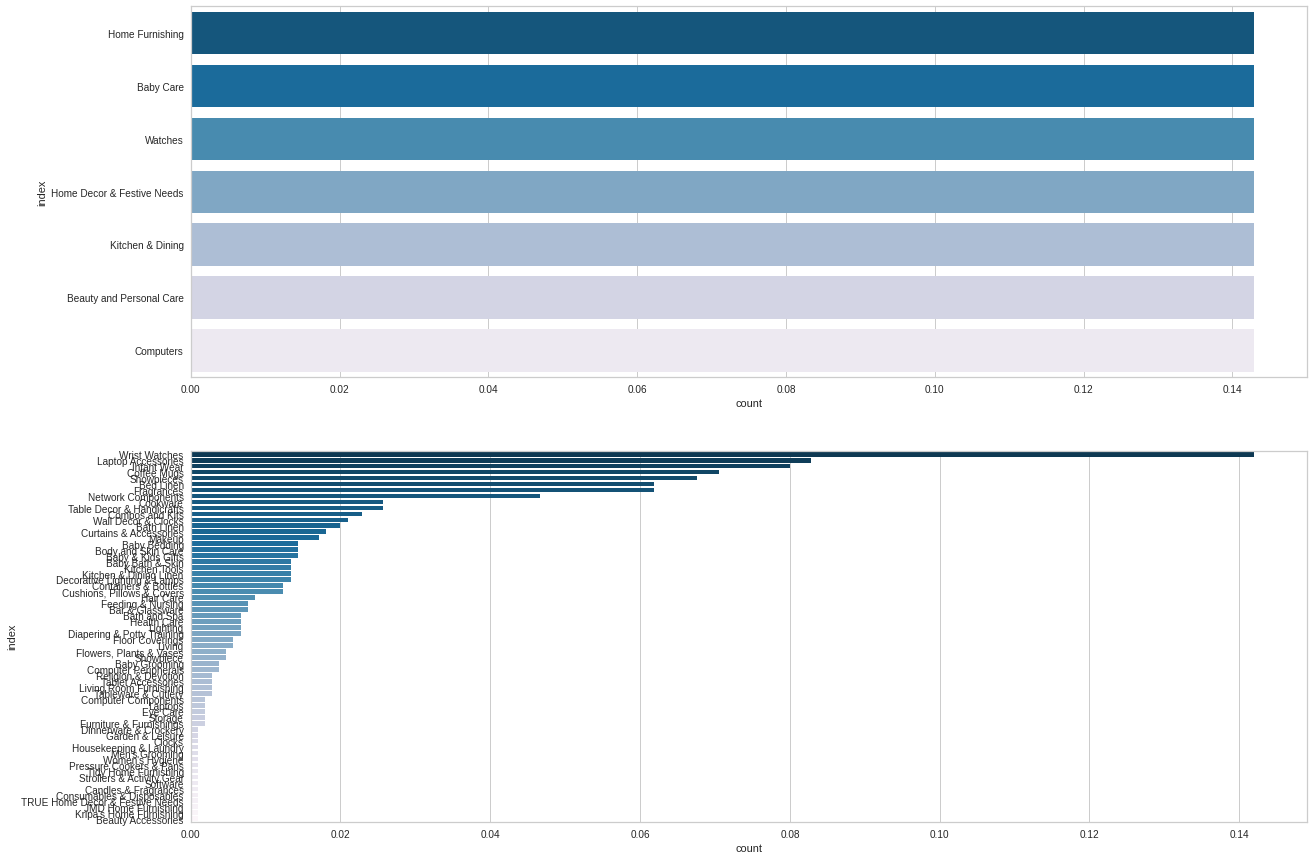

In [ ]:
# Visualisation des deux premiers niveau de catégories
fig, axs = plt.subplots(ncols = 1, nrows = 2, figsize = (20, 15))
sns.barplot(x = 'count', y = 'index', data = cat_0, ax = axs[0], palette = 'PuBu_r')
sns.barplot(x = 'count', y = 'index', data = cat_1, ax = axs[1], palette = 'PuBu_r')
plt.show()

On remarque que la catégorie principale est équillibrée avec 150 produits pour chaque catégorie alors qu'on remarque que pour la sous-catégorie on a une soixantaine de catégories avec un gros désequilibre, on retrouve la même chose pour les autres niveaux. Pour la suite on va continuer avec la catégorie principale et donc 7 catégories.

In [ ]:
# Création d'une nouvelle variable avec la catégories principale
df['target'] = df['product_category_tree'].apply(lambda x: categories(x))

In [ ]:
# création des int labels
labels = list(df.target.unique())
df['target_int'] = df.target.apply(lambda x: int_labels(x, labels))

# <a name = "Extract"> Extraction des features de texte</a> <a href ="#sommaire"> Retour au sommaire</a>

## <a name = "bow">Bag of words</a> <a href ="#sommaire"> Retour au sommaire</a>

### <a name = "bow1">CountVectorizer</a> <a href ="#sommaire"> Retour au sommaire</a>

On va commencer cette extraction de features avec le modèle CountVectorizer qui va permettre de créer une matrice avec le nombre d'apparition de chaque mot.

In [ ]:
vec = CountVectorizer()
X, names = simple_bag_of_words(vec, df, features_names = True)
len(names)

5079

On va appliquer une réduction de dimension avec TSNE qui va faire en sorte que les positons pour chaque point de données dans l'espace à basse dimension soient les plus proches possibles que  celles de l'espace à haute dimension.

In [ ]:
# Réduction de dimension - TSNE
X_embedded = reduc_tsne(X)
# Résultats du kmeans
count_vec_result = kmeans_result(X_embedded, df, 'kmeans_count_vec_')

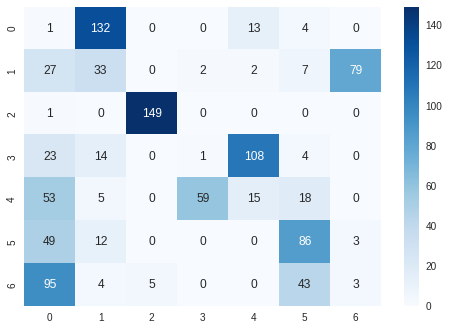

In [ ]:
# Visualisation de matrice de confusion
cm = confusion_matrix(count_vec_result.target_int, count_vec_result.kmeans_count_vec_)
sns.heatmap(cm, annot=True, cmap= 'Blues', fmt='g')
plt.show()

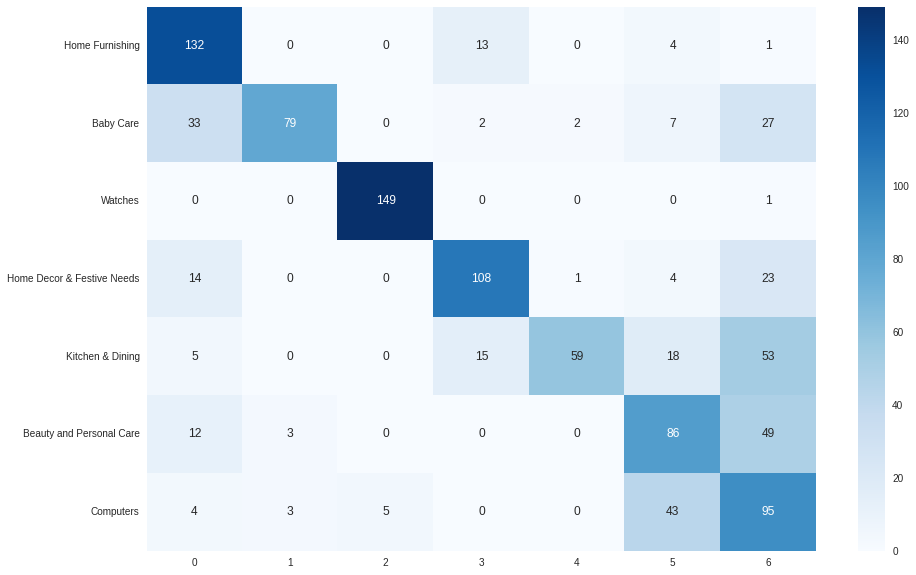

In [ ]:
# Reordonner les clusters
labels_trans = transform_conf_mat(count_vec_result.kmeans_count_vec_,[6, 0, 2, 4, 3, 5, 1])
vis_conf_mat(labels_trans, count_vec_result, 'target_int')

On peut voir qu'on arrive plutôt bien à prédire les catégories comme Watches, Home Furnishing et Home decor. Pour les autres catégories on a beaucoup de mal à les catégoriser voir pas du tout comme par exemple pour la catégorie Beauty and personal care ou encore Kichen and dining.

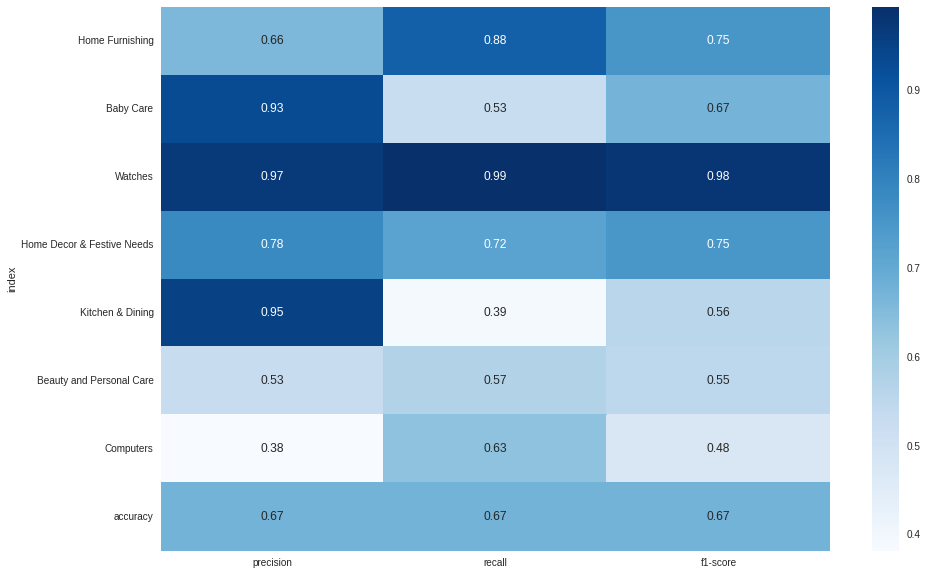

In [ ]:
vis_class_rapport(count_vec_result, 'target_int', labels_trans)

Pour évaluer la qualité de notre clustering on va utiliser le ARI score qui va mesurer le degré de correspondance entre les vraies classes et les classes prédites et le score va varier entre -1 et 1 avec des valeurs proche de 1 qui vont indiquer une correspondance élevée et des valeurs proches de -1 vont indiquer une faible correspondance.

In [ ]:
ari_score = adjusted_rand_score(count_vec_result.target_int, count_vec_result.kmeans_count_vec_)
print(f'ARI score: {round(ari_score, 2)}')

ARI score: 0.43


Ici on a un ARI score plutot bon pour une approche basique.

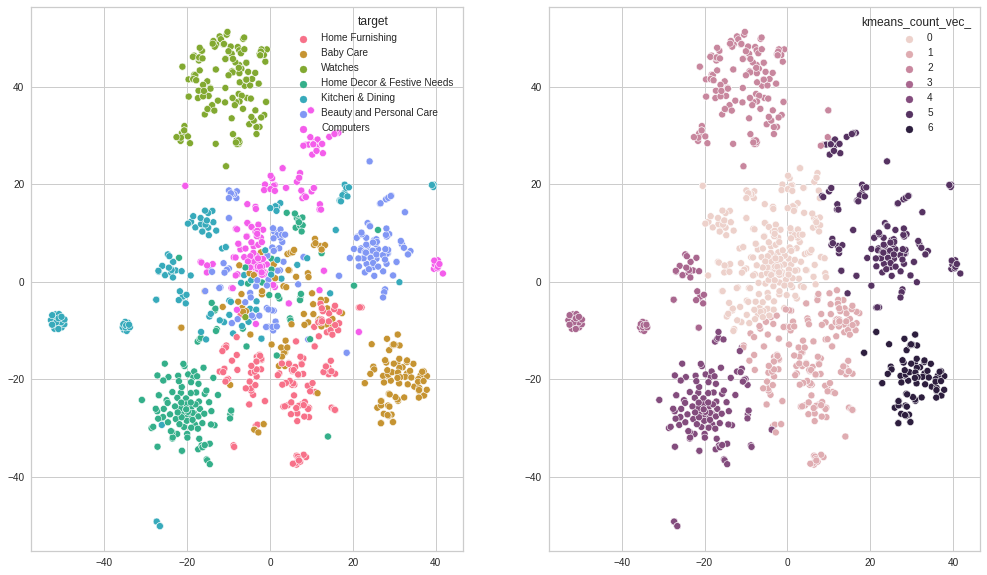

In [ ]:
vis_true_pred(X_embedded, count_vec_result, 'target', 'kmeans_count_vec_')

Comme on l'a vu plus haut les catégories comme Watches, Home Furnishing et Home decor sont très bien classées, on voit qu'ils sont bien regroupés entre eux. Pour les autres clusters on voit que notre modèle a beaucoup de mal du fait que les différents clusters se chevauchent.

### <a name = "bow2">TF-ID</a> <a href ="#sommaire"> Retour au sommaire</a>

Pour le deuxième modèle d'extraction de features on va utiliser TF-IDF qui va être équivalent à CountVectorizer mais ici TF-IDF va mesurer l'importance d'un mot dans nos différentes descriptions en se basant sur: 
- Term Frequency (TF): Cette valeur va indiquer la fréquence d'un mot dans une description. Cette valeur est calculée en comptant le nombre de fois où le mot apparaît dans le document puis en divisant cette valeur par le nombre total de mot dans une description. Plus le mot apparait souvent dans la description plus sa fréquence sera élevée. 
- Inverse Document Frequency (IDF): Cette valeur va indiquer l'importance d'un mot dans l'ensemble des descriptions. Cette valeur est calculée en divisant le nombre de description dans lesquels le mot apparaît par le nombre total de description puis en prenant le log de ce ratio. Et donc plus le mot est rare dans l'ensemble des descriptions plus sont importance est élevée.

Et pour finir TF-IDF est calculée en prenant le produit de la fréquence du mot (TF) et de l'importance du mot (IDF) et donc plus une valeur est élevée plus le mot est important pour une description par rapport à l'ensemble des descriptions

In [ ]:
# Initialisation du modèle
vec_tf = TfidfVectorizer()
X, names = simple_bag_of_words(vec_tf, df, features_names = True)

In [ ]:
# Réduction de dimension avec TSNE
X_embedded_tf_idf = reduc_tsne(X)
tf_idf_result = kmeans_result(X_embedded_tf_idf, df, 'kmeans_tf_idf_')

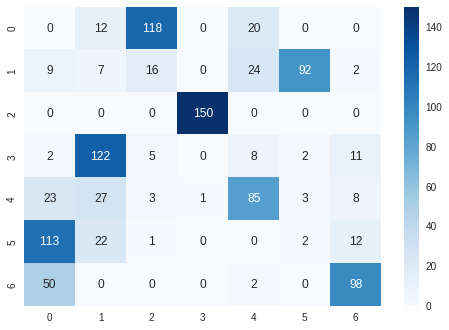

In [ ]:
# Visualisation de matrice de confusion
cm = confusion_matrix(tf_idf_result.target_int, tf_idf_result.kmeans_tf_idf_)
sns.heatmap(cm, annot=True, cmap= 'Blues', fmt='g')
plt.show()

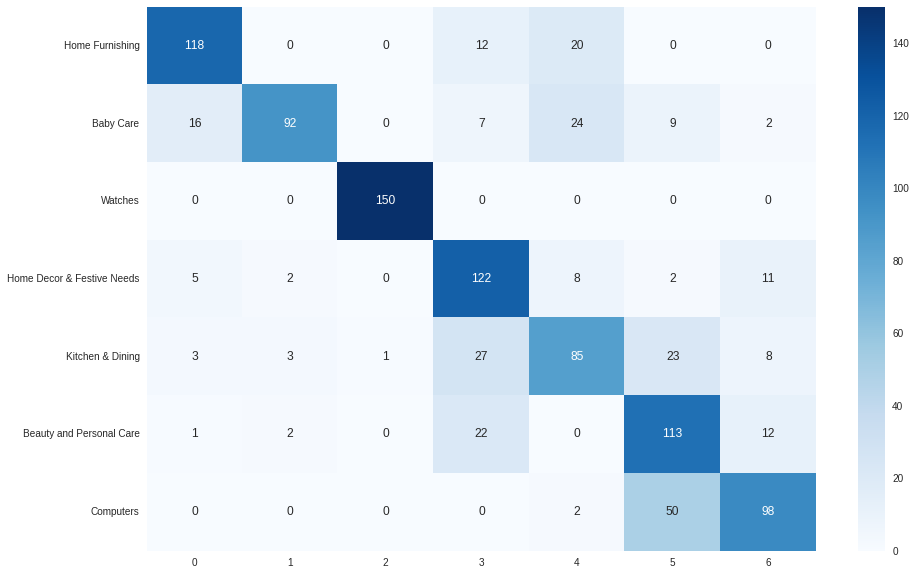

In [ ]:
#Réordonner les labels
labels_trans = transform_conf_mat(tf_idf_result.kmeans_tf_idf_,[5, 3, 0, 2, 4, 1, 6])
vis_conf_mat(labels_trans, tf_idf_result, 'target_int')

On a un résultat plus satisfaisant que CountVectorizer, le modèle arrive à mieux classer la plupart des catégories. Du fait que TF-IDF tient compte de la fréquence et la rareté d'un mot contrairement à CountVectorize qui crée simplement une matrice de comptage.

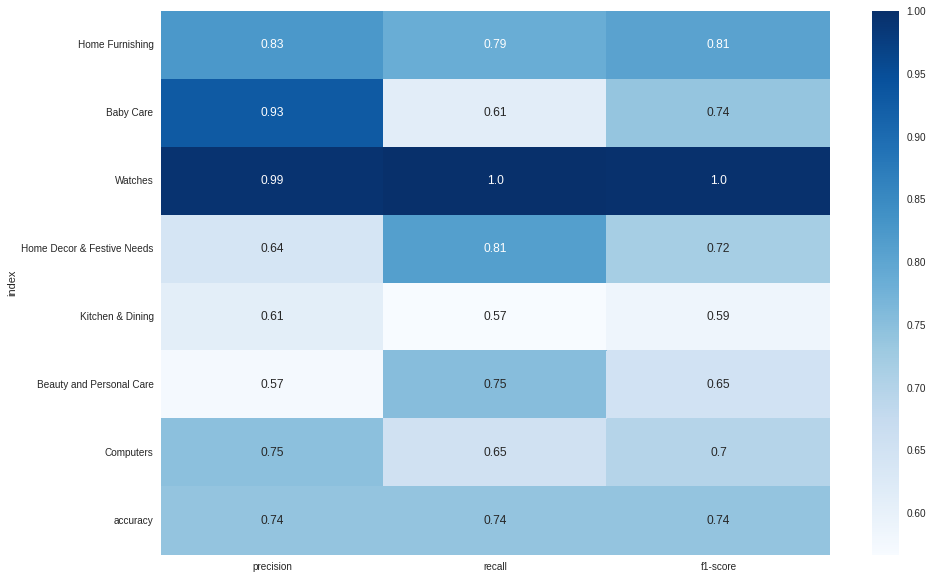

In [ ]:
vis_class_rapport(tf_idf_result, 'target_int', labels_trans)

In [ ]:
ari_score = adjusted_rand_score(tf_idf_result.target_int, tf_idf_result.kmeans_tf_idf_)
print(f'ARI score: {round(ari_score, 2)}')

ARI score: 0.52


On a un ARI score satisfaisant de 0.52

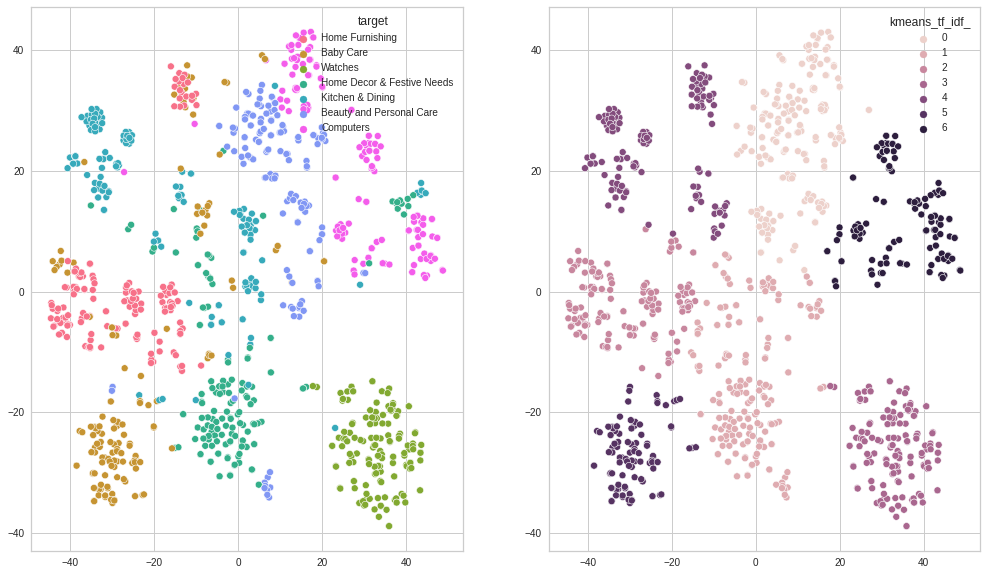

In [ ]:
vis_true_pred(X_embedded_tf_idf, tf_idf_result, 'target', 'kmeans_tf_idf_')

Le résultat se confirme avec la représentation sur les deux premières composantes la plupart des clusters sont bien regroupés entre eux. Mais on voit surtout que le modèle n'est pas adapté ici. On aurait certainement de  bien meilleur résultat avec un modèle basé sur les arbres de décision par exemple.

## <a name = "WE">Word embedding</a> <a href ="#sommaire"> Retour au sommaire</a>

### <a name = "WE1">Word2Vec</a> <a href ="#sommaire"> Retour au sommaire</a>

Pour le troixième modèle d'extraction de features on va utiliser Word2Vec qui va permettre de représenter chaque mot de nos descriptions sous forme de vecteur, ainsi l'objectif est de capturer les relations sémantiques entre les mots de sorte à ce que les mots qui sont similaires soient repésentés par des vecteurs proches.

Word2Vec prend en charge deux architectures CBOW et Skip-gram: 
- CBOW qui va être adapté pour les petits corpus et donc va essayer de prédire le mot central à partir du contexte 
- Skip-gram qui va être adapté au grand corpus qui à partir du mot central on va essayer de prédire le contexte

Ici on utilisera CBOW.


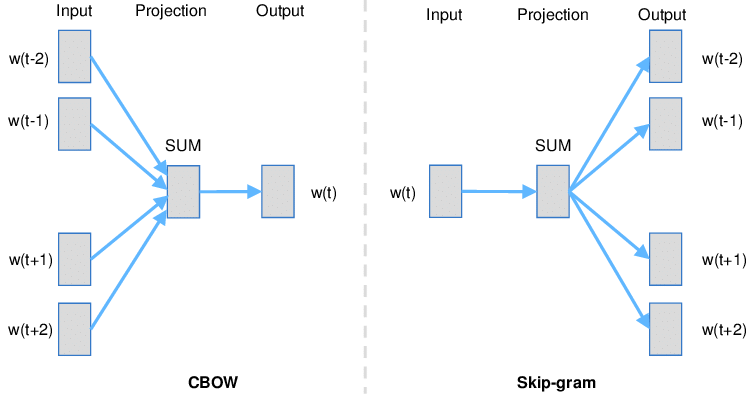

On peut également faire une recherche d'hyperparamètres qu'on fera pas ici comme expliquer au début:
- window_size: Les mots avant et après le mot central. Il est recommandé de tester des valeurs entre 4 et 12. Aucun sens de prendre des valeurs plus élevé
- vector_size: vecteur pour chaque mot. Il est recommendé de tester des valeurs entre 100 et 300. Une valeur plus élevée = temps de calcul très élevé

On va reprendre le même prétraitement que fait auparavent. Sauf que ici on aura une liste de mot pour chaque description comme le veut le modèle.

In [ ]:
text = df['description'].apply(lambda x: text_preprocessing(x, final_join = False))
text[:5]

0    [elegance, polyester, multicolor, abstract, ey...
1    [sathiyas, cotton, bath, towel, specification,...
2    [eurospa, cotton, terry, face, towel, set, key...
3    [santosh, royal, fashion, cotton, printed, kin...
4    [jaipur, print, cotton, floral, king, sized, d...
Name: description, dtype: object

On va initialiser le modèle avec les paramètres par défaut et entrainer le modèle sur nos descriptions. Et créer notre vecteur moyen pour chaques descriptions.

In [ ]:
model = gensim.models.Word2Vec(window = 5, seed  = 0 , size = 300)
model.build_vocab(text)
model.train(text, total_examples = model.corpus_count, epochs = 100)

# traitement de chaque description 
sentences_vec = []

for doc in text:
  vec = sentence_2_vec(doc, model)

  sentences_vec.append(vec)

In [ ]:
mat_vec = np.array(sentences_vec)
mat_vec

array([[-0.18050663,  0.59893692, -0.23736637, ..., -0.35570783,
         0.17886438, -0.08340885],
       [-0.60504368,  0.32549247, -0.10210925, ...,  0.19035909,
        -0.52627175, -0.10845834],
       [-0.30930352,  0.36015052, -0.00744478, ...,  0.25598192,
        -0.30737054, -0.14449391],
       ...,
       [-0.05502623,  0.30578875, -0.23644404, ...,  0.11800172,
        -0.17765951, -0.62286745],
       [ 0.00681688,  0.30298498, -0.2280295 , ...,  0.14027824,
        -0.38635329, -0.73675473],
       [-0.05313302,  0.30311013, -0.18405789, ...,  0.11770707,
        -0.30358307, -0.71609546]])

In [ ]:
mat_vec.shape

(1050, 300)

In [ ]:
# transformation en dataframe
df_vec = pd.DataFrame(mat_vec, columns = ['v' + str(i+1) for i in range(mat_vec.shape[1])])
df_vec.head()

v1        v2        v3        v4        v5        v6        v7  \
0 -0.180507  0.598937 -0.237366  0.004513  0.110119 -0.722472  0.141762   
1 -0.605044  0.325492 -0.102109 -0.283384  0.199165 -0.419731  0.035475   
2 -0.309304  0.360151 -0.007445  0.023821  0.250301 -0.145796  0.102396   
3 -0.335294  0.252940 -0.307788  0.246687  0.565449 -0.518655 -0.249506   
4 -0.384754  0.193186 -0.239708  0.384118  0.721533 -0.550558 -0.086853   

         v8        v9       v10  ...      v291      v292      v293      v294  \
0 -0.212962  0.217340  0.505901  ... -0.067014  0.408816 -0.081717  0.686630   
1  0.386543  0.266222  0.152230  ... -0.234628 -0.405670 -0.096405  0.210426   
2  0.172438  0.123225  0.088797  ... -0.223311 -0.404259 -0.166235  0.289896   
3  0.141521  0.344948  0.459023  ...  0.246449  0.033179 -0.275948  0.534365   
4  0.050142  0.228286  0.438250  ...  0.165958  0.177203 -0.146168  0.571117   

       v295      v296      v297      v298      v299      v300  
0 -0.201174 -0.250997 -0.126784 -0.355708  0.178864 -0.083409  
1  0.129999 -0.099613  0.009253  0.190359 -0.526272 -0.108458  
2  0.038209  0.065520  0.093294  0.255982 -0.307371 -0.144494  
3 -0.245702 -0.308188 -0.229510  0.570889 -0.945314 -0.122614  
4 -0.224643 -0.297836 -0.183001  0.294182 -0.798816 -0.045767  

[5 rows x 300 columns]

In [ ]:
# TSNE
X_embedded_w2v = reduc_tsne(df_vec)
# Résultat Kmeans
w2v_result = kmeans_result(X_embedded_w2v, df, 'kmeans_w2v')

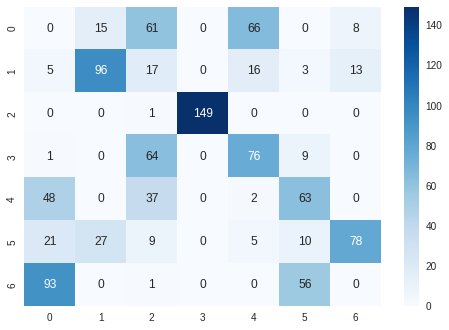

In [ ]:
# Visualisation de la matrice de confusion
cm = confusion_matrix(w2v_result.target_int, w2v_result.kmeans_w2v)
sns.heatmap(cm, annot=True, cmap= 'Blues', fmt='g')
plt.show()

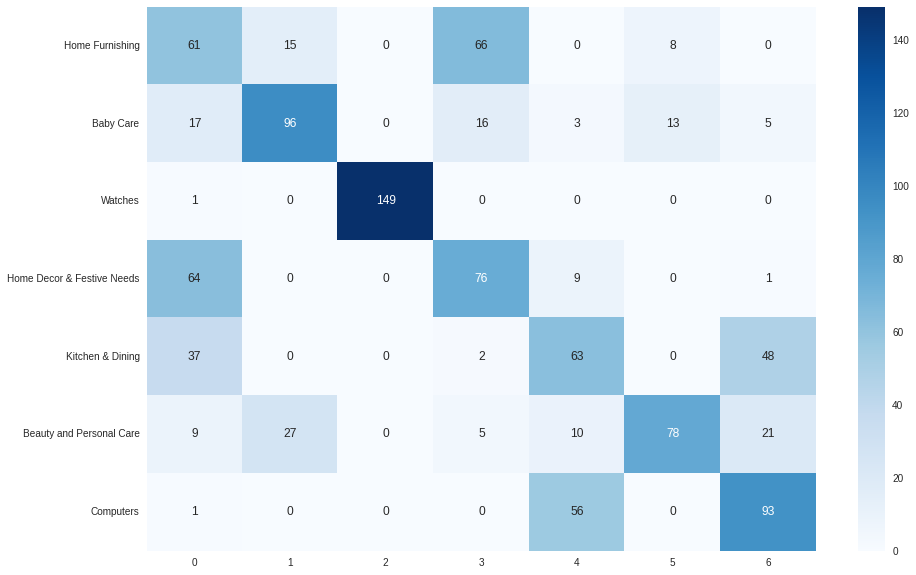

In [ ]:
# Réordonnée les labels
labels_trans = transform_conf_mat(w2v_result.kmeans_w2v,[6, 1, 0, 2, 3, 4, 5])
vis_conf_mat(labels_trans, w2v_result, 'target_int')

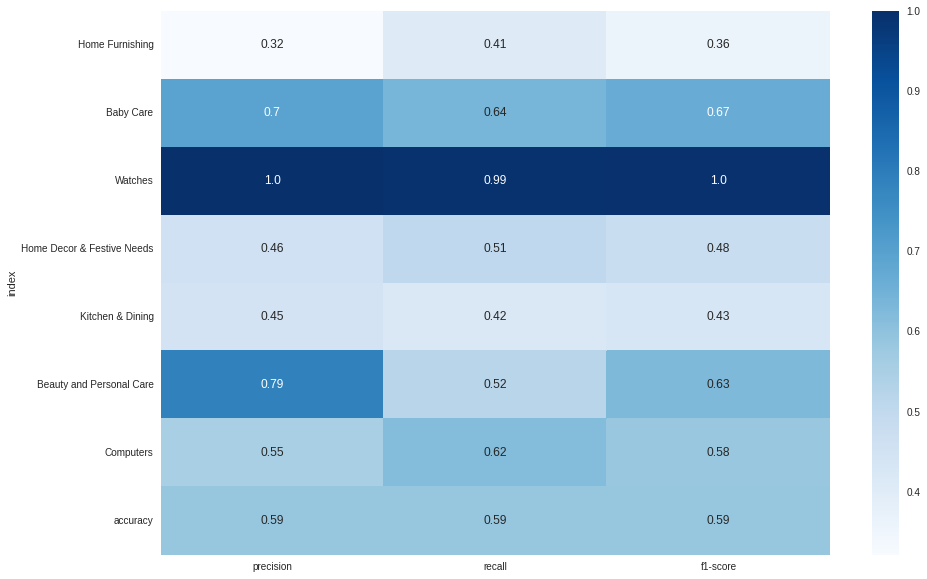

In [ ]:
vis_class_rapport(w2v_result, 'target_int', labels_trans)

In [ ]:
ari_score = adjusted_rand_score(w2v_result.target_int, w2v_result.kmeans_w2v)
print(f'ARI score: {round(ari_score, 2)}')

ARI score: 0.39


Comme le montre la matrice de confusion et le score ARI, on a un modèle moins bon que les méthodes basiques et on peut voir qu'il a beaucoup de mal à classer la plupart des catégories certainement du fait que chaque vecteur est moyennées pour décrire chaque description et donc on perds en information. Ce faible score peut venir également du fait qu'on a entrainé word2vec sur un faible corpus.

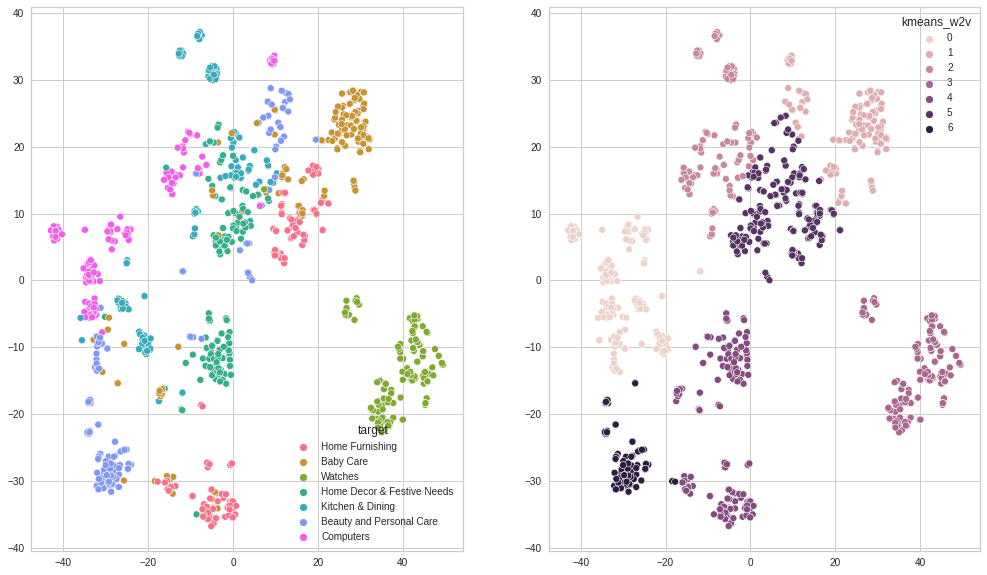

In [ ]:
vis_true_pred(X_embedded_w2v, w2v_result, 'target', 'kmeans_w2v')

Ce qui est confirmé avec la représentation sur les 2 composantes, la plupart des clusters se chevauchent et comme dit avant on aura certainement de bien meilleurs résultats avec un arbre de decision ici aussi.

## <a name = "SE">Sentence embedding</a> <a href ="#sommaire"> Retour au sommaire</a>

### <a name = "SE1">BERT</a> <a href ="#sommaire"> Retour au sommaire</a>

Bert va reprendre le principe du W2V c'est-à-dire générer des vecteurs plus ou moins similaires pour chaque mot. A la différence de w2v qui va generer un vecteur fixe pour un mot quelque soit le contexte, Bert va generer des vecteurs pour chaque mot en fonction de la phrase entière en capturant le sens d'un mot. Et contrairement à Word2Vec, Bert peut également renvoyer un vecteur pour une description complete et ainsi comme Word2Vec utiliser cette représentation vectorielle pour classer les différentes catégories.

**W2V exemple:**
- He didn't receive fair treatment 
- Fun fair in NY city this summer 

Fair vecteur: [1, 0.9, 0.2, 1, 0.7]

**Bert exemple**: 
- He didn't receive fair treatment -> Fair vecteur: [1, 0.9, 0.2, 1, 0.7]
- Tom deserves unbiased judgement -> unbiased vecteur: [1, 0.8, 0.2, 1, 0.6]
- Fun fair in NY city this summer -> Fair vecteur: [0, 0.1, 0,  0.5, 0.4]
- Carnival was packed with fun activies -> carnival: [0, 0.1, 0.1, 0.5, 0.5]


In [ ]:
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

bert_preprocess_model = hub.KerasLayer(preprocess_url)

text_bert = df['description'].apply(lambda x: text_preprocessing(x))
text_bert[:5]

0    elegance polyester multicolor abstract eyelet ...
1    sathiyas cotton bath towel specification sathi...
2    eurospa cotton terry face towel set key featur...
3    santosh royal fashion cotton printed king size...
4    jaipur print cotton floral king sized double b...
Name: description, dtype: object

In [ ]:
text_preprocessed = bert_preprocess_model(text_bert)

bert_model = hub.KerasLayer(encoder_url)
bert_result = bert_model(text_preprocessed)
bert_vecteur = bert_result['pooled_output']

mat_vec_bert = np.array(bert_vecteur)
df_vec_bert = pd.DataFrame(mat_vec_bert, columns = ['v' + str(i+1) for i in range(mat_vec_bert.shape[1])])
df_vec_bert.head()

v1        v2        v3        v4        v5        v6        v7  \
0 -0.786013 -0.372895 -0.534331  0.671171  0.238066 -0.130114  0.714461   
1 -0.825361 -0.612600 -0.921054  0.816502  0.692695 -0.297040  0.787933   
2 -0.695755 -0.393007 -0.591202  0.605902  0.278318 -0.095779  0.706947   
3 -0.724737 -0.557835 -0.921592  0.737203  0.759304 -0.310565  0.718070   
4 -0.803535 -0.560872 -0.844704  0.723994  0.650058 -0.257762  0.715850   

         v8        v9       v10  ...      v759      v760      v761      v762  \
0  0.306111  0.043745 -0.999957  ...  0.481240 -0.070464  0.438976  0.751639   
1  0.492042 -0.534128 -0.999984  ...  0.539797 -0.342700  0.890378  0.790654   
2  0.353020  0.039733 -0.999968  ...  0.524757  0.200918  0.354452  0.654305   
3  0.487383 -0.644687 -0.999967  ...  0.587474 -0.341838  0.888505  0.637149   
4  0.479058 -0.465897 -0.999982  ...  0.643727 -0.041624  0.738952  0.749374   

       v763      v764      v765      v766      v767      v768  
0  0.212246  0.464268  0.507081 -0.395788 -0.636721  0.716865  
1  0.131486  0.082131  0.626094 -0.816943 -0.650438  0.703683  
2  0.322691  0.243621  0.537696 -0.530092 -0.513473  0.635805  
3  0.107161  0.082396  0.599759 -0.835153 -0.626854  0.559838  
4  0.210068  0.292892  0.680152 -0.734240 -0.669441  0.728039  

[5 rows x 768 columns]

In [ ]:
X_embedded_bert = reduc_tsne(df_vec_bert)
bert_result = kmeans_result(X_embedded_bert, df, 'kmeans_bert')

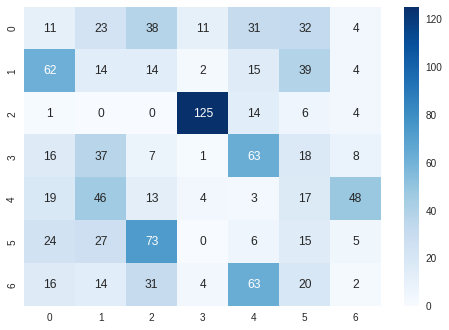

In [ ]:
cm = confusion_matrix(bert_result.target_int, bert_result.kmeans_bert)
sns.heatmap(cm, annot=True, cmap= 'Blues', fmt='g')
plt.show()

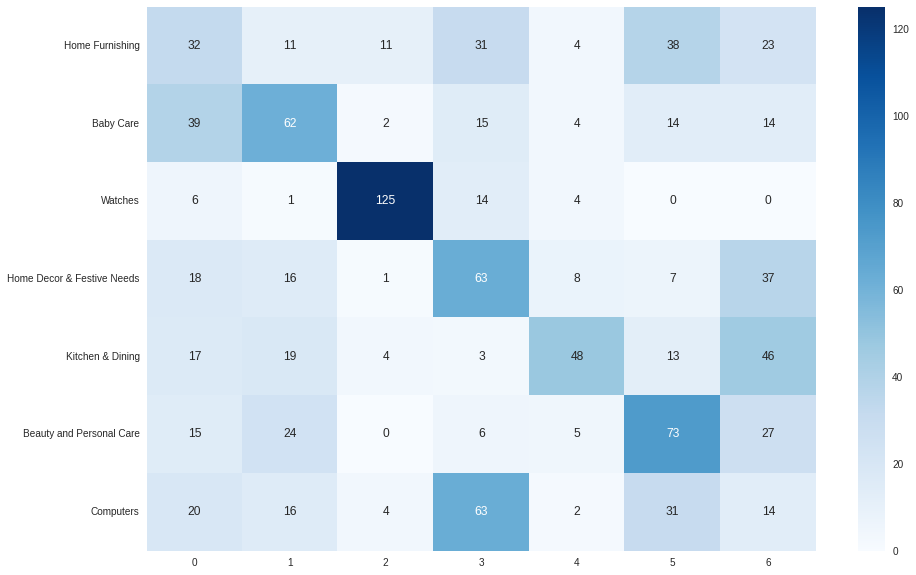

In [ ]:
labels_trans = transform_conf_mat(bert_result.kmeans_bert,[1, 6, 5, 2, 3, 0, 4])
vis_conf_mat(labels_trans, bert_result, 'target_int')

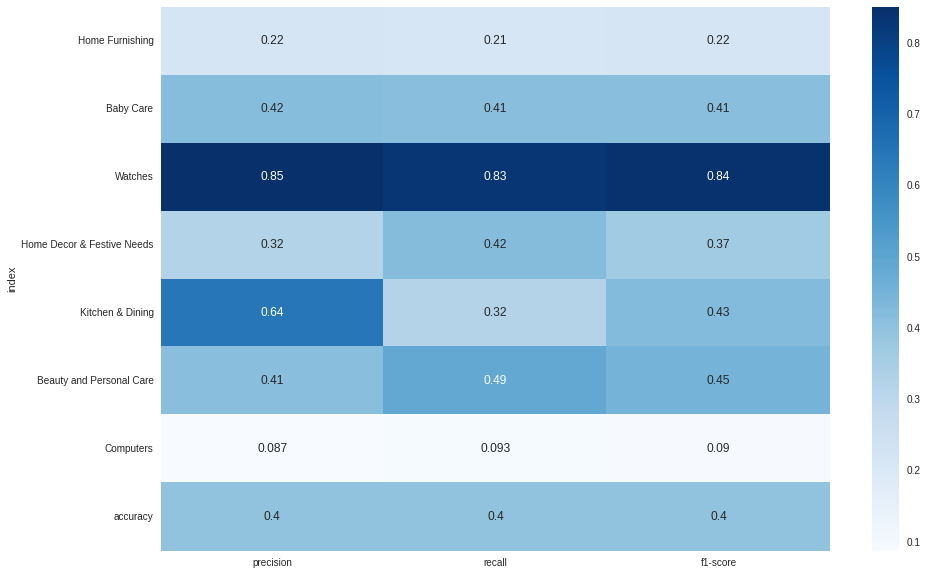

In [ ]:
vis_class_rapport(bert_result, 'target_int', labels_trans)

In [ ]:
ari_score = adjusted_rand_score(bert_result.target_int, bert_result.kmeans_bert)
print(f'ARI score: {round(ari_score, 2)}')

ARI score: 0.19


Avec le modèle bert on a le score le plus mauvais, au vu de la matrice de confusion on voit que le modèle a du mal à classer toutes les catégories. Le résultat obtenu peut se justifier par le modèle pré-entrainé choisi qui n'est pas adapté à notre corpus.

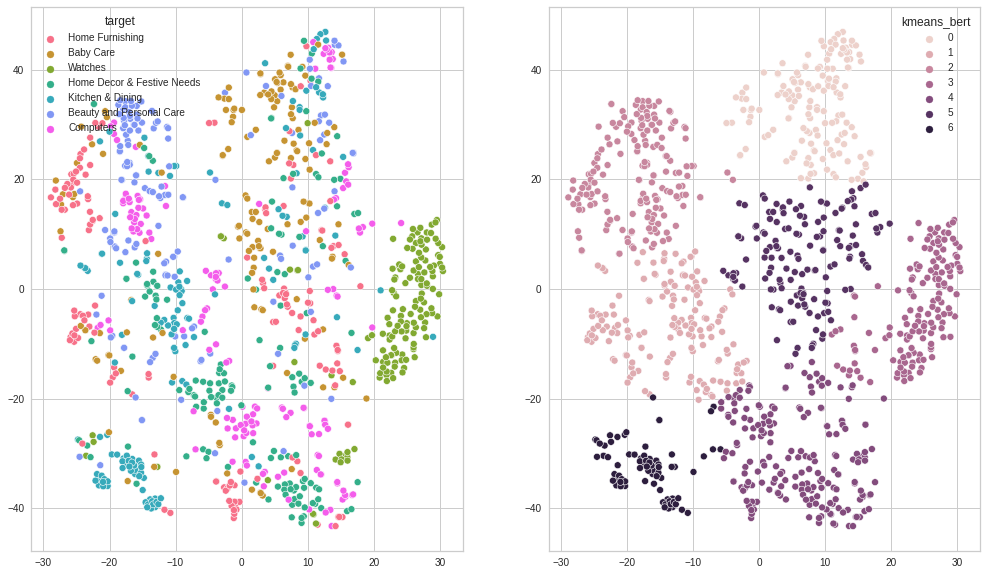

In [ ]:
vis_true_pred(X_embedded_bert, bert_result, 'target', 'kmeans_bert')

ça se confirme sur la représentation sur les deux composantes, tous les clusters se chevauchent. 

### <a name = "SE1">USE</a> <a href ="#sommaire"> Retour au sommaire</a>

USE va être dans la même logique que Bert c'est-à-dire représenter ici nos descriptions sous forme de vecteur en capturant le sens.

Il existe deux variantes de USE transformer et deep averaging network (DAN):
- Transfomer: 
  - Plus précis mais plus gourmand en reccources
  - Utile pour la classification de sentiment, ou il y a des mots comme "not" qui peuvent changer le sens d'une phrase  et traiter la double négation comme "not bad"
- DAN:
  - Moins gourmand mais moins précis
  - Moins de précision sur la double négation et le sarcasme
  - Très bon modèle pour classer les articles ou autres en catégories

Ici on utilisera la deuxième variante.


In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
use_vec = embed(text_bert)
use_vec

<tf.Tensor: shape=(1050, 512), dtype=float32, numpy=
array([[-0.05251594, -0.05266799,  0.03817198, ...,  0.04527253,
         0.04399703, -0.03285964],
       [-0.04915247, -0.046577  , -0.0092502 , ...,  0.02752651,
         0.04525386,  0.0335695 ],
       [-0.05273794, -0.05048446, -0.02880947, ...,  0.04988892,
        -0.00414194, -0.03578064],
       ...,
       [-0.00235252, -0.04827848, -0.01597754, ..., -0.0435418 ,
         0.05648927, -0.06445741],
       [-0.00215771, -0.0466244 ,  0.0568264 , ...,  0.01603025,
        -0.03211587, -0.0223098 ],
       [-0.04565243, -0.03604626,  0.05140958, ...,  0.01983155,
        -0.03759754, -0.00072316]], dtype=float32)>

In [ ]:
mat_vec_use = np.array(use_vec)
df_vec_use = pd.DataFrame(mat_vec_use, columns = ['v' + str(i+1) for i in range(mat_vec_use.shape[1])])
df_vec_use.head()

v1        v2        v3        v4        v5        v6        v7  \
0 -0.052516 -0.052668  0.038172  0.049857  0.022438  0.050957 -0.025088   
1 -0.049152 -0.046577 -0.009250  0.036074  0.053561  0.057812  0.046017   
2 -0.052738 -0.050484 -0.028809  0.052481  0.050590  0.052500  0.047502   
3 -0.053326 -0.052324  0.052783  0.051212  0.053308  0.041827  0.000712   
4 -0.051663 -0.050108  0.049900  0.048043  0.051655  0.047951 -0.012916   

         v8        v9       v10  ...      v503      v504      v505      v506  \
0  0.045278 -0.041074 -0.010598  ... -0.045930 -0.052861 -0.052241  0.052750   
1 -0.034600 -0.020229 -0.042571  ...  0.023949 -0.057703 -0.051180 -0.046898   
2  0.032416 -0.043453  0.040088  ...  0.047309 -0.052797 -0.049804  0.009528   
3  0.022365  0.015308 -0.049321  ... -0.042750 -0.053328  0.018607  0.052779   
4  0.041476  0.003889 -0.044065  ... -0.046926 -0.051673 -0.048884  0.049720   

       v507      v508      v509      v510      v511      v512  
0  0.006825 -0.051814  0.049630  0.045273  0.043997 -0.032860  
1 -0.019110 -0.052410  0.016077  0.027527  0.045254  0.033570  
2  0.048693 -0.052502  0.047900  0.049889 -0.004142 -0.035781  
3 -0.050863 -0.052266  0.053044  0.052841 -0.036293 -0.044779  
4 -0.051530 -0.051407  0.051646  0.051632 -0.027544 -0.028780  

[5 rows x 512 columns]

In [ ]:
X_embedded_use = reduc_tsne(df_vec_use)
use_result = kmeans_result(X_embedded_use, df, 'kmeans_use')

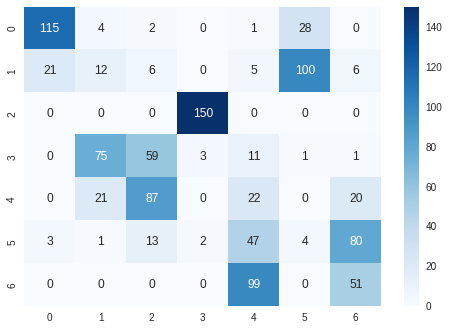

In [ ]:
cm = confusion_matrix(use_result.target_int, use_result.kmeans_use)
sns.heatmap(cm, annot=True, cmap= 'Blues', fmt='g')
plt.show()

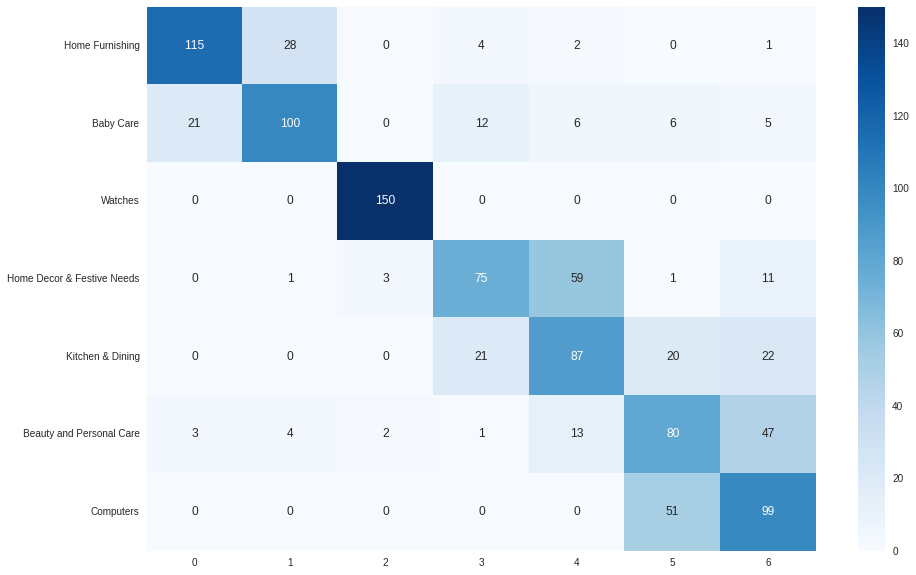

In [ ]:
labels_trans = transform_conf_mat(use_result.kmeans_use,[0, 3, 4, 2, 6, 1, 5])
vis_conf_mat(labels_trans, use_result, 'target_int')

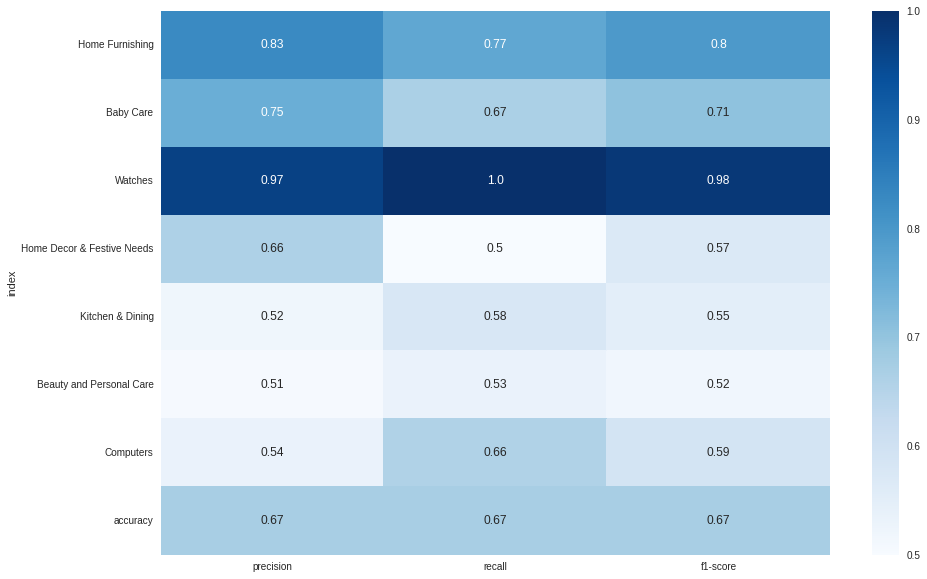

In [ ]:
vis_class_rapport(use_result, 'target_int', labels_trans)

In [ ]:
ari_score = adjusted_rand_score(use_result.target_int, use_result.kmeans_use)
print(f'ARI score: {round(ari_score, 2)}')

ARI score: 0.46


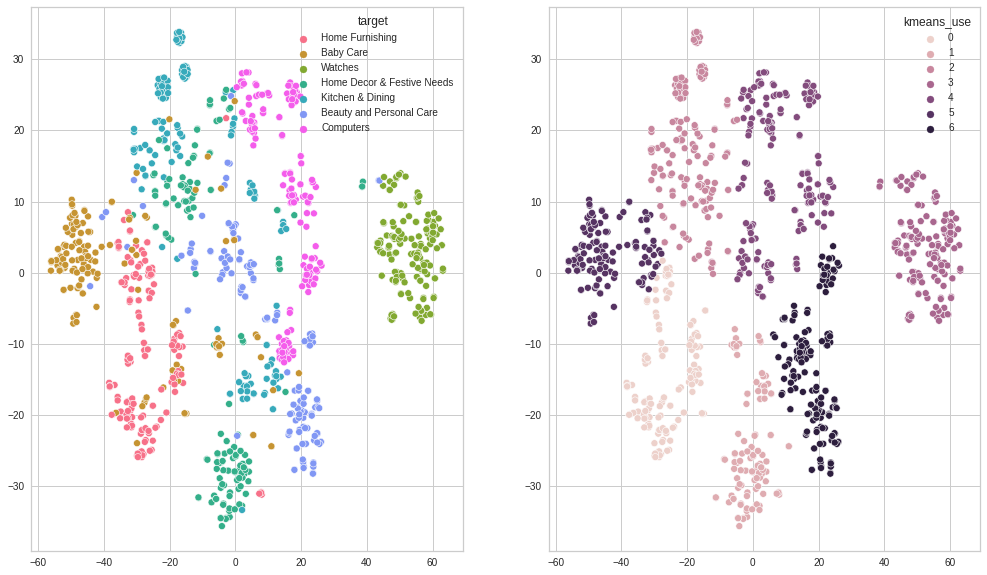

In [ ]:
vis_true_pred(X_embedded_use, use_result, 'target', 'kmeans_use')

Ici comme les modèles précédents on a un résultat assez similaire que ce soit sur le score ARI mais aussi la capacité à classer certaines catégories que d'autres. Comme on a pu le voir ici des modèles comme BERT ou USE sont moins performants que des modèles plus basiques comme le CountVectorizer ou TF-IDF dû au choix du modèle pré-entrainé mais également dû à la capacité de se géneraliser à de nouvelles données

In [ ]:
#reducer = umap.UMAP(n_neighbors = 150, n_components = 10)
#embedding_umap = reducer.fit_transform(df_vec_use)

 # <a name = "Extract1"> Extraction des features d'images</a> <a href ="#sommaire"> Retour au sommaire</a>

### <a name = "EXT1">ORB</a> <a href ="#sommaire"> Retour au sommaire</a>

Pour l'extraction de features à partir d'une image on va utiliser ORB qui va permettre pour chaque image de detecter des points clés c'est-à-dire des régions de l'image qui se distinguent comme les coins ou les bords grâce à l'algorithmes FAST. Ensuite pour chaque points clé ORB va crée un descripteur qui sera représenté par vecteur, qui sera pas sensible à la rotation de l'image.

Le choix de ORB est principalement du au faite que ORB est aussi performant que SIFT (et meilleure que SURF)  tout en étant presque deux ordres de grandeur plus rapide.

Pour la suite on va continuer sans l'image 518124b75d6c6dfee4c2e4c0cfa716a.jpg qui excéde la limite de pixel, et pour éviter le crash du nootbook.

In [ ]:
path = '/content/drive/MyDrive/P6 classification/Images'
#list_image_name = os.listdir(path)
df_remove = df[~df.image.isin(['5518124b75d6c6dfee4c2e4c0cfa716a.jpg'])].copy()
list_image_name = list(df_remove.image)
list_image_name[:5]

['55b85ea15a1536d46b7190ad6fff8ce7.jpg',
 '7b72c92c2f6c40268628ec5f14c6d590.jpg',
 '64d5d4a258243731dc7bbb1eef49ad74.jpg',
 'd4684dcdc759dd9cdf41504698d737d8.jpg',
 '6325b6870c54cd47be6ebfbffa620ec7.jpg']

In [ ]:
image = plt.imread(path + '/' + '5518124b75d6c6dfee4c2e4c0cfa716a.jpg')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


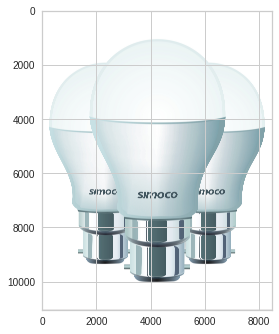

In [ ]:
plt.imshow(image)
plt.show()

Avant d'appliquer ORB aux différentes images on va proceder à quelques prétraitement comme:
- La redimension de l'image qui va permettre d'accélèrer le processus d'extraction. Ici on va prendre 60% de la longueur et de la largueur
- Mettre l'image en noir et blanc qui va permettre de réduire le nombre de pixels d'une image et donc les calculs
- Réduction du bruit en appliquant un flou gaussien qui va permettre d'harmoniser les détails d'une image.
- Appliquer une égalisation avec l'algorithme CLAHE(Contrast Limited Adaptive Histogram Equalization) qui va permettre d'améliorer le contraste des différentes images en créent ce contraste par petites régions de l'image plutôt qu'en se basant sur l'histogramme global de l'image.

Après avoir effectuer ces différent prétraiement sur chaque image on va utiliser l'algorithme ORB pour récuperer les descripteurs.

In [ ]:
orb_desc = []
orb = cv2.ORB_create()

for img in list_image_name:
  print(f'Nom image: {img}')
  image = plt.imread(path + '/' +img)
  print('------------- Image rescale -------------')
  image_rescaled = rescale(image,0.6, anti_aliasing=True, multichannel = True)
  print('------------- RGB to gray -------------')
  # conversion de l'image en noir et blanc 
  img_gray = color.rgb2gray(image) 
  print('------------- Drop noise -------------')
  # Flou gaussien: uniformiser les partie d'une image, en les floutants et donc hamoniser les détails d'une image
  # multichannel = False -> Si l'image n'est pas coloré
  img_noise = gaussian(img_gray, multichannel= False) #Le filtre gaussien estompe les bords et réduit le contraste
  print('------------- Equalization -------------')
  image_eq = exposure.equalize_adapthist(img_noise, clip_limit = 0.01) # clip_limit -> normalisée entre 0 et 1 (des valeurs élevées donnent plus de contraste a l'image): optionnel
  print('------------- Format cv2 -------------')
  cv_image = img_as_ubyte(image_eq)
  print('------------- Keypoint and descriptor -------------')
  kp, dsc = orb.detectAndCompute(cv_image, None)
  orb_desc.append(dsc)

orb_dsc_by_img = np.array(orb_desc, dtype=object)
orb_dsc_all = np.concatenate(orb_dsc_by_img)
orb_dsc_all.shape

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
------------- Format cv2 -------------
------------- Keypoint and descriptor -------------
Nom image: 353ddb2c8ab6920d8ad1055abee87dda.jpg
------------- Image rescale -------------
------------- RGB to gray -------------
------------- Drop noise -------------
------------- Equalization -------------
------------- Format cv2 -------------
------------- Keypoint and descriptor -------------
Nom image: 6634de7b39a5b0658c74ab098450096d.jpg
------------- Image rescale -------------
------------- RGB to gray -------------
------------- Drop noise -------------
------------- Equalization -------------
------------- Format cv2 -------------
------------- Keypoint and descriptor -------------
Nom image: 7680c6bf930669dc0646e3315187dc8c.jpg
------------- Image rescale -------------
------------- RGB to gray -------------
------------- Drop noise -------------
------------- Equalization -------------
------------- Forma

(508697, 32)

A partir des 508 697 descripteurs obtenus on va créer un bag of visual words qui va permettre de représenter chacunes des images sous forme de vecteurs.

In [ ]:
# K = nombre de catégorie * 10 
k = 70

kmeans = KMeans(n_clusters = k, random_state = 0)
kmeans.fit(orb_dsc_all)

img_vec = []
for i, img_dsc in enumerate(orb_dsc_by_img):
  hist = build_histogram(kmeans, img_dsc, i)
  img_vec.append(hist)

In [ ]:
img_features = np.array(img_vec)
df_img_features = pd.DataFrame(img_features, columns = ['v'+str(i+1) for i in range(img_features.shape[1])])
df_img_features.head()

v1     v2     v3     v4     v5     v6     v7     v8     v9    v10  ...  \
0  0.084  0.002  0.012  0.022  0.022  0.028  0.006  0.008  0.006  0.006  ...   
1  0.004  0.006  0.012  0.008  0.030  0.002  0.012  0.014  0.008  0.010  ...   
2  0.036  0.006  0.024  0.006  0.010  0.016  0.010  0.006  0.004  0.000  ...   
3  0.024  0.004  0.024  0.026  0.032  0.014  0.000  0.008  0.010  0.016  ...   
4  0.020  0.008  0.008  0.036  0.034  0.006  0.006  0.016  0.010  0.010  ...   

     v61    v62    v63    v64    v65    v66    v67    v68    v69    v70  
0  0.006  0.022  0.008  0.032  0.006  0.012  0.022  0.006  0.038  0.002  
1  0.012  0.030  0.016  0.006  0.032  0.004  0.026  0.020  0.022  0.006  
2  0.024  0.018  0.004  0.042  0.012  0.046  0.012  0.010  0.018  0.016  
3  0.002  0.010  0.010  0.016  0.020  0.012  0.026  0.000  0.028  0.010  
4  0.002  0.012  0.012  0.008  0.014  0.028  0.028  0.010  0.014  0.010  

[5 rows x 70 columns]

In [ ]:
X_embedded_orb = reduc_tsne(df_img_features)
orb_result = kmeans_result(X_embedded_orb, df_remove, 'kmeans_orb')

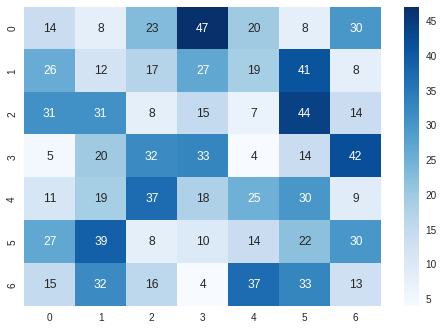

In [ ]:
cm = confusion_matrix(orb_result.target_int, orb_result.kmeans_orb)
sns.heatmap(cm, annot=True, cmap= 'Blues', fmt='g')
plt.show()

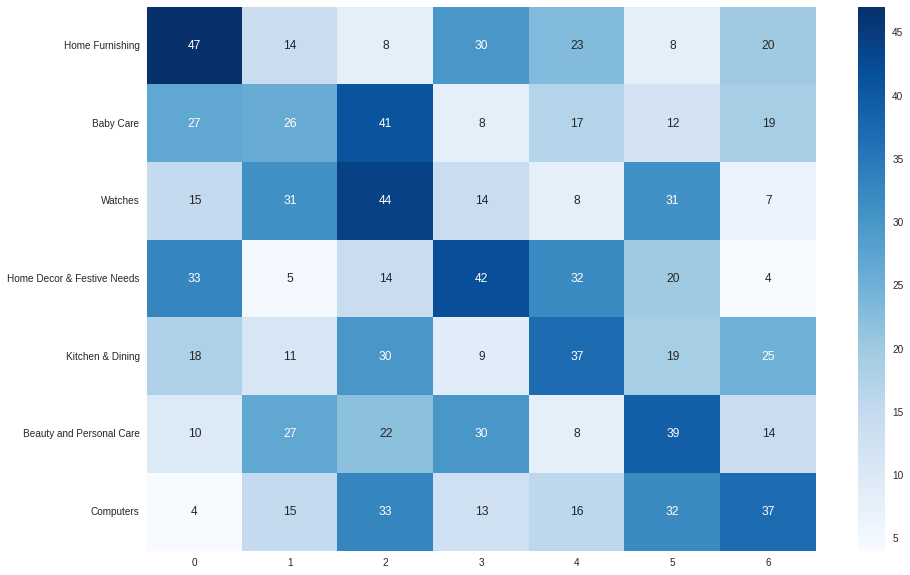

In [ ]:
labels_trans = transform_conf_mat(orb_result.kmeans_orb,[1, 5, 4, 0, 6, 2, 3])
vis_conf_mat(labels_trans, orb_result, 'target_int')

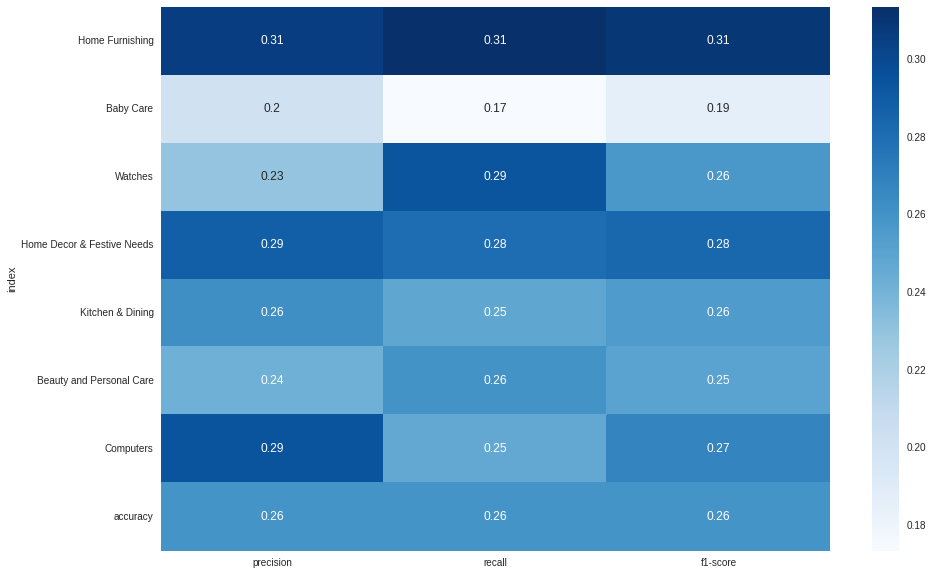

In [ ]:
vis_class_rapport(orb_result, 'target_int', labels_trans)

In [ ]:
ari_score = adjusted_rand_score(orb_result.target_int, orb_result.kmeans_orb)
print(f'ARI score: {round(ari_score, 2)}')

ARI score: 0.04


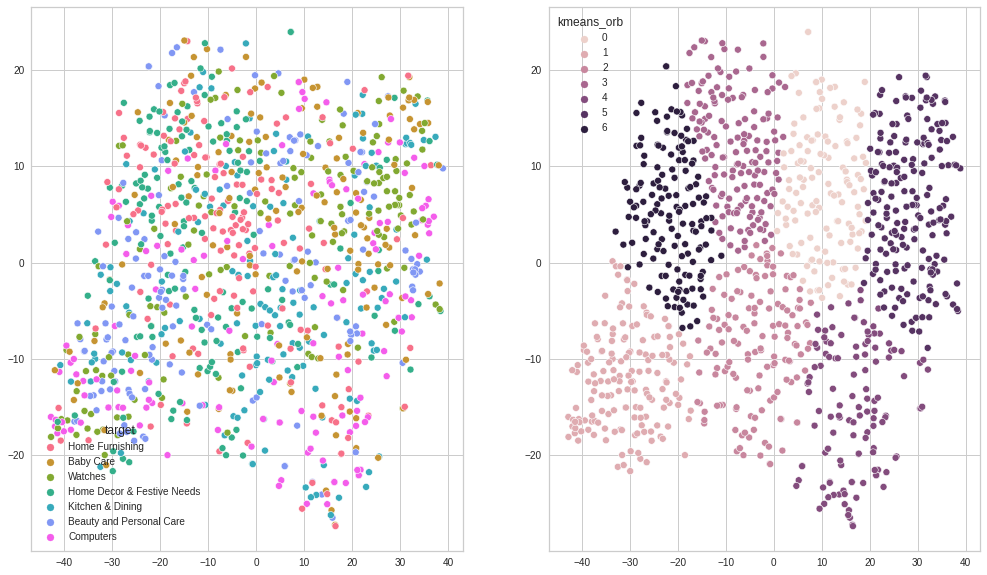

In [ ]:
vis_true_pred(X_embedded_orb, orb_result, 'target', 'kmeans_orb')

On obtient un ARI score très mauvais, on remarque également sur les deux composantes que tous les clusters se chevauchent. Cela peut se jutifier par le fait que les features extraites à l'aide de ORB ne sont pas assez discriminantes pour séparer correctement les différents types d'objets dans les images.

### <a name = "EXT2">VGG16</a> <a href ="#sommaire"> Retour au sommaire</a>

Pour la deuxième méthode d'extraction de features à partir d'une photo on va utiliser VGG16 qui a été pré-entrainé sur une grande base de données d'images (ImageNet). Le but ici va être d'utiliser VGG16 pour extraire les features de chaque image pour ça, on va utiliser VGG16 sans la dernière couche, ce qui va signifier que pour chaque image on aura un vecteur de 4096 qui décrira chaque image.

Avant d'appliquer le modèle VGG16 aux différentes images on va proceder à quelques prétraitements comme:
- Mettre les pixels de l'image en np array
- Redimensionner l'image en 224, 224 comme le veut le modèle 
- Utiliser la fonction preprocess_input de keras qui va permettre d'adapter l'image au format requis par le modèle. Comme par exemple normaliser les valeurs des pixels.

Après ça, on peut utiliser le modèle VGG16 pour extraire les features.

In [ ]:
model = VGG16()

model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
features = []

for img in list_image_name:
  print(f'Nom image: {img}')
  image = tf.keras.utils.load_img(path + '/' +img, target_size=(224, 224))
  print('------------- Image pixels to np array -------------')
  image = tf.keras.utils.img_to_array(image)
  print('------------- Reshape data -------------')
  image =image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  print('------------- Image preprocess -------------')
  image = preprocess_input(image)
  print('------------- Extract features -------------')
  features.append(model.predict(image))

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Nom image: 02a53d335775b652f22f41b529b9d646.jpg
------------- Image pixels to np array -------------
------------- Reshape data -------------
------------- Image preprocess -------------
------------- Extract features -------------
Nom image: 69446af66066146718cd569f87e99fff.jpg
------------- Image pixels to np array -------------
------------- Reshape data -------------
------------- Image preprocess -------------
------------- Extract features -------------
Nom image: b4d35b6536b623c83b293eb3a1c02bba.jpg
------------- Image pixels to np array -------------
------------- Reshape data -------------
------------- Image preprocess -------------
------------- Extract features -------------
Nom image: f01140c02fd09e5c56312a64fa8db3da.jpg
------------- Image pixels to np array -------------
------------- Reshape data -------------
------------- Image preprocess -------------
------------- Extract features --------

In [ ]:
features_vec = np.concatenate(features)
df_img_features_vgg16 = pd.DataFrame(features_vec, columns = ['v'+str(i+1) for i in range(features_vec.shape[1])])
df_img_features_vgg16.head()

v1        v2   v3        v4        v5        v6        v7   v8   v9  \
0  3.398614  0.859572  0.0  1.106560  2.266122  2.927241  2.446448  0.0  0.0   
1  0.000000  0.000000  0.0  1.172009  0.000000  0.000000  0.000000  0.0  0.0   
2  0.000000  0.000000  0.0  4.457807  0.000000  0.000000  0.000000  0.0  0.0   
3  0.000000  0.070991  0.0  2.046283  0.000000  0.000000  0.000000  0.0  0.0   
4  3.417152  0.000000  0.0  0.000000  1.012359  0.000000  0.000000  0.0  0.0   

        v10  ...     v4087  v4088  v4089     v4090     v4091     v4092  \
0  0.000000  ...  0.485876    0.0    0.0  0.472938  0.875756  0.783684   
1  6.499799  ...  1.169696    0.0    0.0  0.000000  0.000000  3.152507   
2  2.820566  ...  0.000000    0.0    0.0  0.000000  0.000000  5.270284   
3  0.894023  ...  0.000000    0.0    0.0  0.000000  0.000000  3.977747   
4  0.000000  ...  0.000000    0.0    0.0  0.000000  0.000000  9.195916   

      v4093   v4094     v4095  v4096  
0  0.000000  0.0000  0.851055    0.0  
1  0.000000  0.0000  0.000000    0.0  
2  0.000000  1.2971  0.000000    0.0  
3  0.000000  0.0000  0.000000    0.0  
4  0.139736  0.0000  1.735950    0.0  

[5 rows x 4096 columns]

In [ ]:
X_embedded_vgg16 = reduc_tsne(df_img_features_vgg16)
vgg16_result = kmeans_result(X_embedded_vgg16, df_remove, 'kmeans_vgg16')

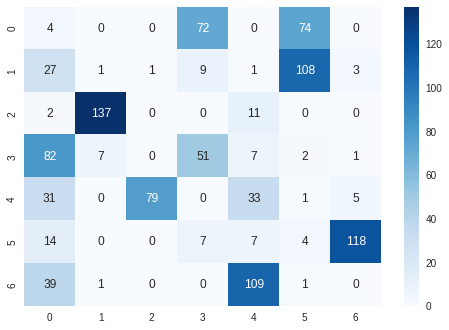

In [ ]:
cm = confusion_matrix(vgg16_result.target_int, vgg16_result.kmeans_vgg16)
sns.heatmap(cm, annot=True, cmap= 'Blues', fmt='g')
plt.show()

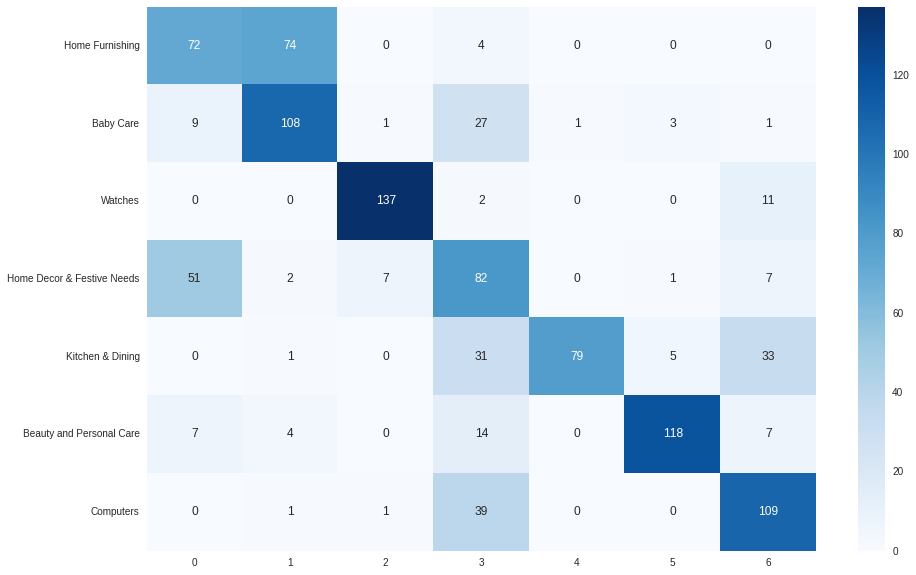

In [ ]:
labels_trans = transform_conf_mat(vgg16_result.kmeans_vgg16,[3, 2, 4, 0, 6, 1, 5])
vis_conf_mat(labels_trans, vgg16_result, 'target_int')

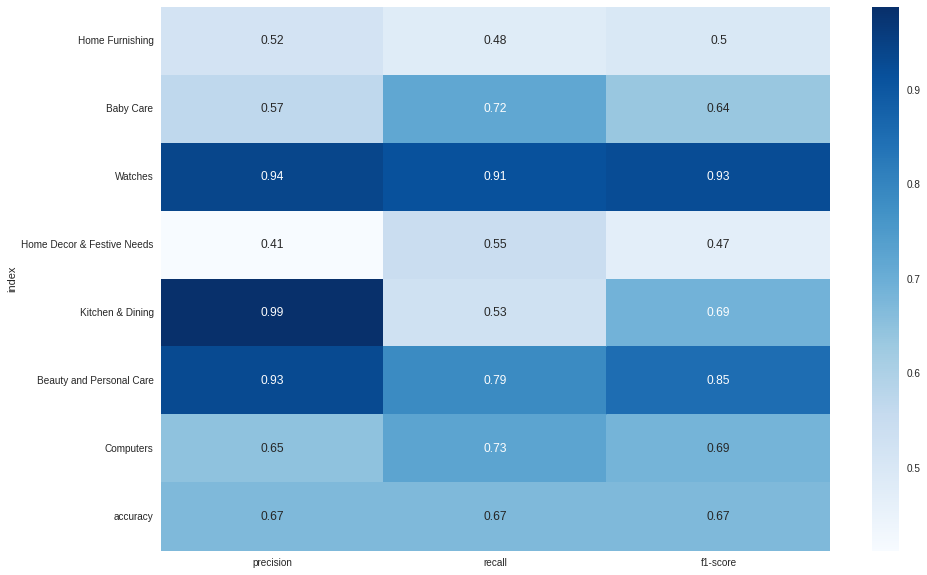

In [ ]:
vis_class_rapport(vgg16_result, 'target_int', labels_trans)

In [ ]:
ari_score = adjusted_rand_score(vgg16_result.target_int, vgg16_result.kmeans_vgg16)
print(f'ARI score: {round(ari_score, 2)}')

ARI score: 0.46


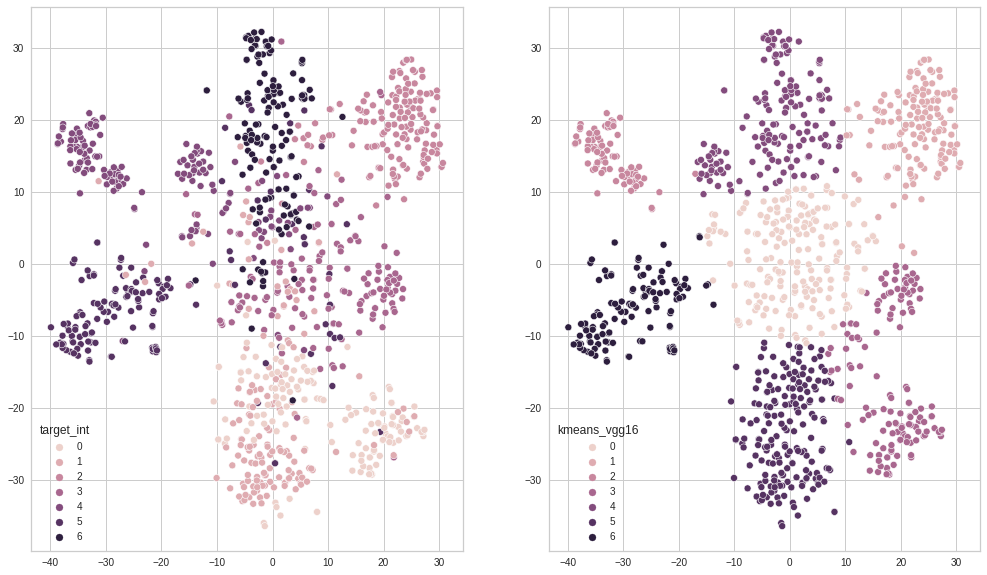

In [ ]:
vis_true_pred(X_embedded_vgg16, vgg16_result, 'target', 'kmeans_vgg16')

On obtient un bien meilleur résultat avec vgg16 qu'avec orb avec un score plutôt bon. La raison de cette différence peut venir du fait que VGG16 a été entrainé sur un très grand nombre d'image et a appris à extraire les caractéristiques les plus importantes et donc les features génerer par VGG16 sont plus discriminantes que celle de ORB pour ce problème.
Ici on voit que la plupart des clusters ont bien été classés comme les catégories Watches, Baby care, Beauty and personal care et computers.

### <a name = "Extract3">VGG16 + TF-IDF</a> <a href ="#sommaire"> Retour au sommaire</a>

Ici le but va être de concatener les features generer par TF-IDF qui a eu le meilleur score pour la partie texte avec les features qui ont été generé par VGG16 et qui a eu le meilleur score pour la partie image et voir si on peut obtenir un meilleure score en combinant ces deux approches.

In [ ]:
df_remove['description_new'] = df_remove['description'].apply(lambda x: text_preprocessing(x))

In [ ]:
# Initialisation du modèle
vec_tf = TfidfVectorizer()
X, names = simple_bag_of_words(vec_tf, df_remove, features_names = True)

In [ ]:
df_tf_idf = pd.DataFrame(X.todense())
df_tf_idf.columns = names

In [ ]:
df_tf_idf_vgg16 = pd.concat([df_img_features_vgg16, df_tf_idf], axis = 1)
df_tf_idf_vgg16.head()

v1        v2   v3        v4        v5        v6        v7   v8   v9  \
0  3.398614  0.859572  0.0  1.106560  2.266122  2.927241  2.446448  0.0  0.0   
1  0.000000  0.000000  0.0  1.172009  0.000000  0.000000  0.000000  0.0  0.0   
2  0.000000  0.000000  0.0  4.457807  0.000000  0.000000  0.000000  0.0  0.0   
3  0.000000  0.070991  0.0  2.046283  0.000000  0.000000  0.000000  0.0  0.0   
4  3.417152  0.000000  0.0  0.000000  1.012359  0.000000  0.000000  0.0  0.0   

        v10  ...  zinc  zingalalaa  zip  zipexterior  zipper  zippered  zone  \
0  0.000000  ...   0.0         0.0  0.0          0.0     0.0       0.0   0.0   
1  6.499799  ...   0.0         0.0  0.0          0.0     0.0       0.0   0.0   
2  2.820566  ...   0.0         0.0  0.0          0.0     0.0       0.0   0.0   
3  0.894023  ...   0.0         0.0  0.0          0.0     0.0       0.0   0.0   
4  0.000000  ...   0.0         0.0  0.0          0.0     0.0       0.0   0.0   

   zoom  zora  zyxel  
0   0.0   0.0    0.0  
1   0.0   0.0    0.0  
2   0.0   0.0    0.0  
3   0.0   0.0    0.0  
4   0.0   0.0    0.0  

[5 rows x 9173 columns]

In [ ]:
X_embedded_tf_vgg = reduc_tsne(df_tf_idf_vgg16)
vgg16_tf_result = kmeans_result(X_embedded_tf_vgg, df_remove, 'kmeans_vgg16_tf')

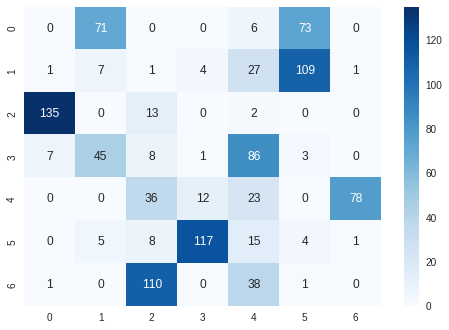

In [ ]:
cm = confusion_matrix(vgg16_tf_result.target_int, vgg16_tf_result.kmeans_vgg16_tf)
sns.heatmap(cm, annot=True, cmap= 'Blues', fmt='g')
plt.show()

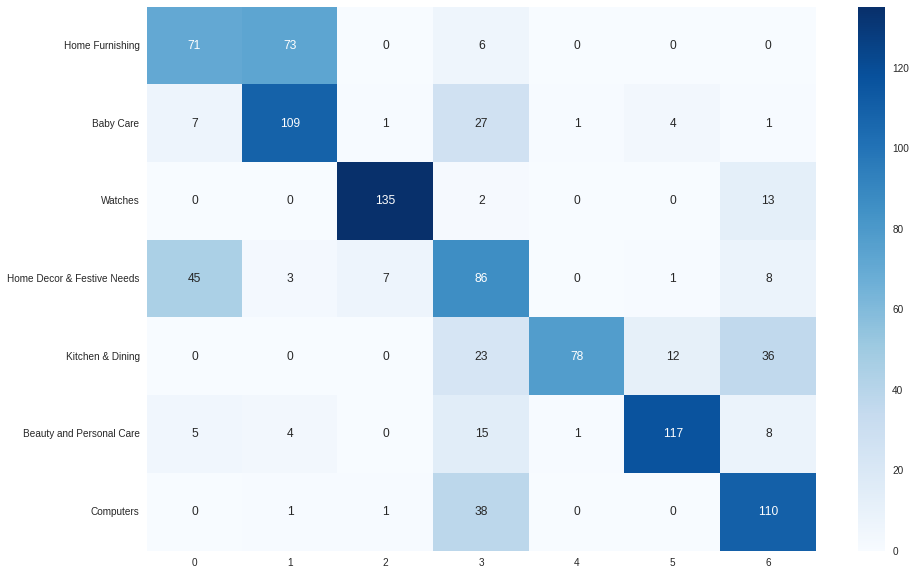

In [ ]:
labels_trans = transform_conf_mat(vgg16_tf_result.kmeans_vgg16_tf,[2, 0, 6, 5, 3, 1, 4])
vis_conf_mat(labels_trans, vgg16_tf_result, 'target_int')

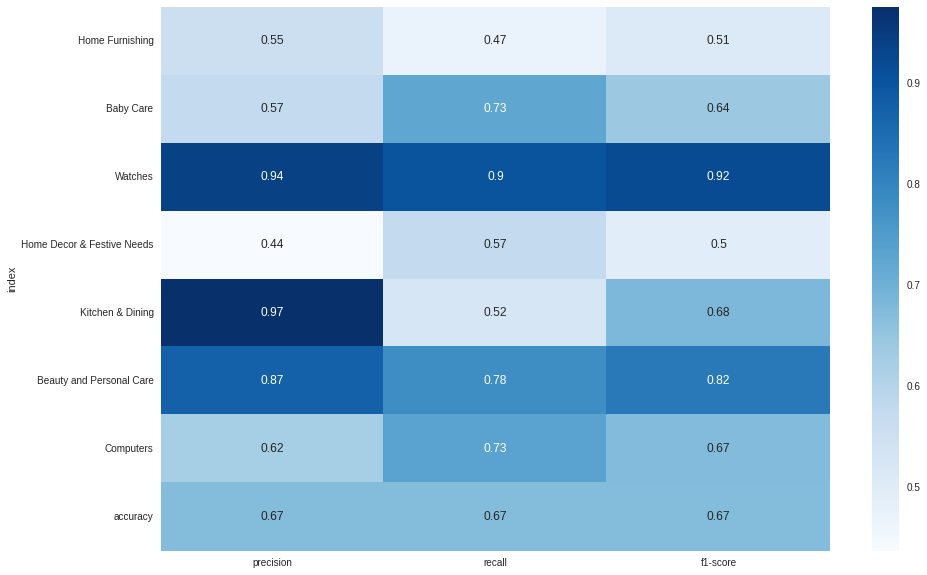

In [ ]:
vis_class_rapport(vgg16_tf_result, 'target_int', labels_trans)

In [ ]:
ari_score = adjusted_rand_score(vgg16_tf_result.target_int, vgg16_tf_result.kmeans_vgg16_tf)
print(f'ARI score: {round(ari_score, 2)}')

ARI score: 0.45


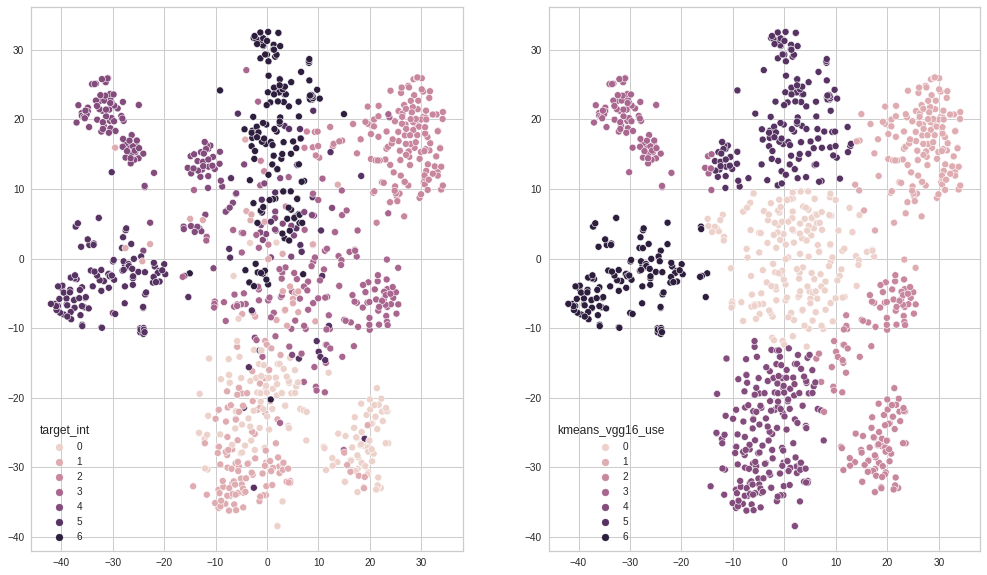

In [ ]:
vis_true_pred(X_embedded_tf_vgg, vgg16_tf_result, 'target', 'kmeans_vgg16_use')